In [1]:
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
import tensorflow as tf

from collections import Counter
from pathlib import Path
from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

2024-03-23 15:24:21.427533: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 15:24:21.427642: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 15:24:21.561391: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# ELEC0135 Assignment

## Introduction

Based on the competition here: https://www.kaggle.com/competitions/cassava-leaf-disease-classification

## Source Data

As this is an exploratory Kaggle notebook, I've just loaded in the hosted `cassava-leaf-diesease-classification` dataset in here.  The final script will need some data loading logic, so that it can be submitted for testing/marking purposes.

In [2]:
SOURCE_DATA = Path("/kaggle/input/cassava-leaf-disease-classification/")

WORKING_DATA = Path("/kaggle/working/data/elec0135-assignment-cld/")
WORKING_DATA.mkdir(parents=True, exist_ok=True)

# Parameters
IMAGE_SIZE = 255
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.25
EPOCHS = 50
ES = True
ES_PATIENCE = 5

## EDA

### What are we looking at?

In [3]:
with open(SOURCE_DATA / "label_num_to_disease_map.json", "r") as label_file:
    print(json.dumps(json.load(label_file),indent=2))

{
  "0": "Cassava Bacterial Blight (CBB)",
  "1": "Cassava Brown Streak Disease (CBSD)",
  "2": "Cassava Green Mottle (CGM)",
  "3": "Cassava Mosaic Disease (CMD)",
  "4": "Healthy"
}


### Class Balance

In [4]:
df_train = pd.read_csv(SOURCE_DATA / "train.csv")
df_train.groupby(['label']).count()

image_id
label          
0          1087
1          2189
2          2386
3         13158
4          2577

There's a large class imbalance here for `0` (CBB), which will need taking into account during the training.  Initial thoughts are that this will be especially true if I end up using a binary-classification gate in a `Mixture of Experts` model.

### Some Sample Images

In [5]:
def get_image_path(image_id: str) -> Path:
    return SOURCE_DATA / "train_images" / image_id

In [6]:
im = Image.open(get_image_path(df_train.loc[0, "image_id"]))
print(im.size)

(800, 600)


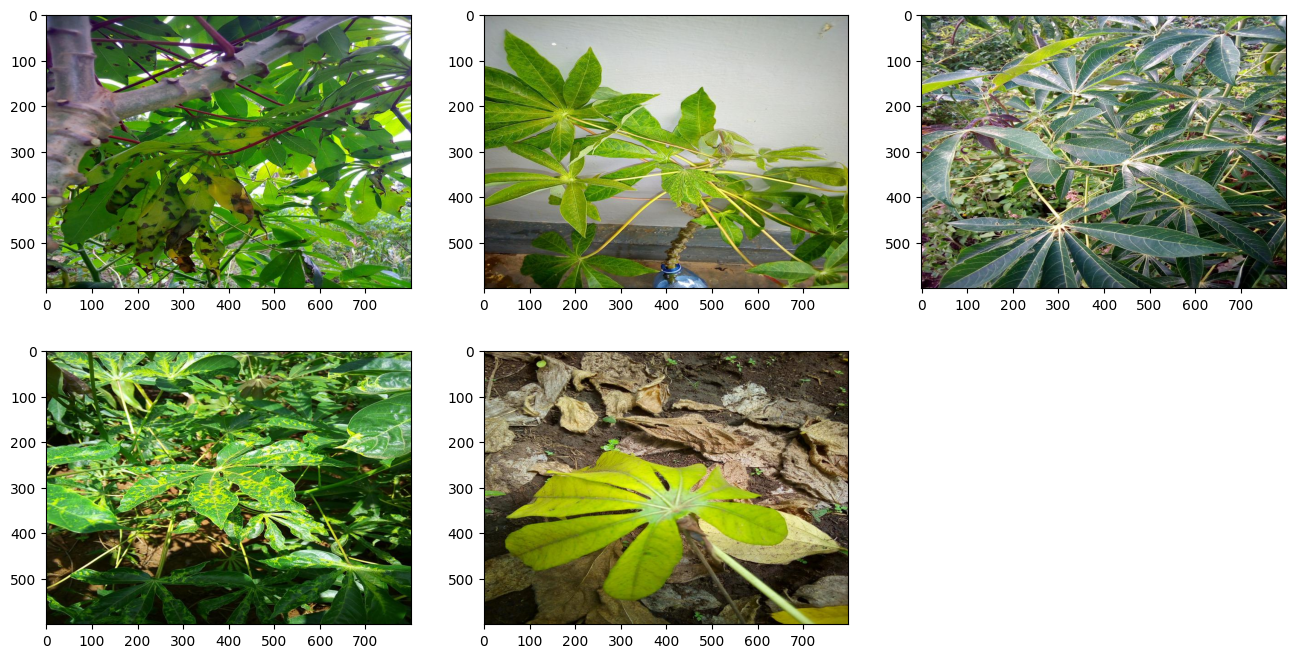

In [7]:
df_single_sample = df_train.groupby('label').apply(lambda x: x.sample(1), include_groups = False).reset_index()

fig, axs = plt.subplots(2, 3, figsize=(16, 8))
plt.axis('off')

for index, row in df_single_sample.iterrows():
    lab = row["label"]
    image_id = row["image_id"]
    a = plt.imread(get_image_path(image_id))
    axs[int(index/3), index%3].imshow(a)

There's high variability in the images - some closer shots, some further away etc.

## Data Processing

With only ~1000 instances of label/class `0`, my first thought is that some data augmentation is going to be required here.  I'm going to hold off with that first and see how a basic VGG-style network, such as that explored in the labs, fares.

Ideas:

* Data Augmentation
* For the assignment, shrink the images to make the data aspect more manageable
* Train on full (unbalanced) dataset
* Train on balanced (smaller) dataset

In [8]:
def create_equal_split_dataset(df_map: pd.DataFrame) -> Path:
    es_path = WORKING_DATA / "equal_split"
    if not es_path.exists:
        es_path.mkdir(parents=True, exist_ok=True)

        for lab in df_map.label.unique():
            (es_path / str(lab)).mkdir(exist_ok=True)

        source_path = SOURCE_DATA / "train_images"

        # take n first items from each class
        df_map['counter'] = 1
        df_map['class_count'] = df_map[['label', 'counter']].groupby(['label']).cumsum()

        for index, row in df_map.iterrows():
            lab = row["label"]
            image_id = row["image_id"]
            img = source_path / image_id
            dest = es_path / str(lab) / image_id

            class_count = row["class_count"]
            if class_count > 1087:
                continue
            shutil.copyfile(img, dest)
        
    return es_path


def get_equal_split_dataset(path: Path):
    # Load dataset
    # categorical here means that the labels are one-hot encoded
    ds_train_, ds_valid_ = image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[IMAGE_SIZE, IMAGE_SIZE],
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=VALIDATION_SPLIT,
        subset="both",
        seed=31415,
    )   

    def convert_to_float(image, label):
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = image / 255.0
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    return ds_train, ds_valid


def plot_experiment_results(df_history: pd.DataFrame, exp_id: str, epoch_limit = EPOCHS) -> None:
    df = df_history[(df_history.exp_id == exp_id) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_loss = df[["epoch", "loss", "val_loss"]].groupby(["epoch"]).mean()
    df_loss_gap = df[["epoch", "loss_gap"]].groupby(["epoch"]).mean()
    df_acc = df[["epoch", "accuracy", "val_accuracy"]].groupby(["epoch"]).mean()
    df_loss.plot()
    df_loss_gap.plot()
    df_acc.plot();
    
def plot_experiments_comp(df_history: pd.DataFrame, exp_id: list, y_dim: str, epoch_limit = EPOCHS) -> None:
    df = df_history[(df_history.exp_id.isin(exp_id)) & (df_history.epoch <= epoch_limit)].copy()
    df["loss_gap"] = df.val_loss - df.loss
    df_grp = df[["epoch","exp_id", y_dim]].groupby(["epoch", "exp_id"]).mean()
    sns.lineplot(data=df_grp, x="epoch", y=y_dim, hue="exp_id")

In [9]:
dataset_path = create_equal_split_dataset(df_train)

In [10]:
ds_train, ds_valid = get_equal_split_dataset(dataset_path)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.


## Model

Create a baseline first using a very simple model, such as that seen in the labs.  How well does it do with the limited / equal weight split?

Random model / baseline would be 20% (since five classes of equal weight).

In [12]:
# df_experiment = pd.DataFrame(columns=["exp_id", "desc", "batch_size", "img_width", "img_height", "model"])
# df_history = pd.DataFrame(columns=["loss", "accuracy", "val_loss", "val_accuracy"])

In [13]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [11]:
def run_experiment(exp_id: str, sub_exp_id: int, model_fn: str, ds_train_, ds_valid_):
    
    #data = {"exp_id":"1", "desc":"something", "batch_size":BATCH_SIZE, "img_width":0, "img_height":0, "model": model_str}
    #df_experiment = pd.concat([pd.DataFrame([data]), df_experiment])
    
    model = model_fn()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=ES_PATIENCE,
        restore_best_weights=True,
    )
    
    cbs = []
    if ES:
        print("Using EarlyStopping")
        cbs += [early_stopping]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=EPOCHS,
        verbose=1,
        callbacks=cbs
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist


def add_results(df_all_results, df_new_results):
    if df_all_results.empty:
        return df_new_results
    else:
        return pd.concat([df_all_results, df_new_results])

In [15]:
df_results = pd.DataFrame

In [16]:
# set early stopping to false just to get a full look at the training
ES = False

# starting point for the batch-size
BATCH_SIZE = 64
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("1", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50


I0000 00:00:1709139692.658253     191 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


64/64 [==============================] - 19s 134ms/step - loss: 1.6106 - accuracy: 0.1960 - val_loss: 1.6088 - val_accuracy: 0.1907
Epoch 2/50
64/64 [==============================] - 4s 57ms/step - loss: 1.6089 - accuracy: 0.2014 - val_loss: 1.6071 - val_accuracy: 0.1981
Epoch 3/50
64/64 [==============================] - 4s 58ms/step - loss: 1.6061 - accuracy: 0.2166 - val_loss: 1.6013 - val_accuracy: 0.2445
Epoch 4/50
64/64 [==============================] - 4s 57ms/step - loss: 1.5948 - accuracy: 0.2468 - val_loss: 1.6128 - val_accuracy: 0.2246
Epoch 5/50
64/64 [==============================] - 4s 57ms/step - loss: 1.5779 - accuracy: 0.2494 - val_loss: 1.5505 - val_accuracy: 0.3218
Epoch 6/50
64/64 [==============================] - 4s 58ms/step - loss: 1.5352 - accuracy: 0.2835 - val_loss: 1.5239 - val_accuracy: 0.3343
Epoch 7/50
64/64 [==============================] - 4s 58ms/step - loss: 1.4987 - accuracy: 0.3012 - val_loss: 1.4651 - val_accuracy: 0.3704
Epoch 8/50
64/64 [====

In [ ]:
sns.lineplot(data=df_results2[df_results2.exp_id=="1"], x="epoch", y="val_loss", hue="sub_exp_id")

35

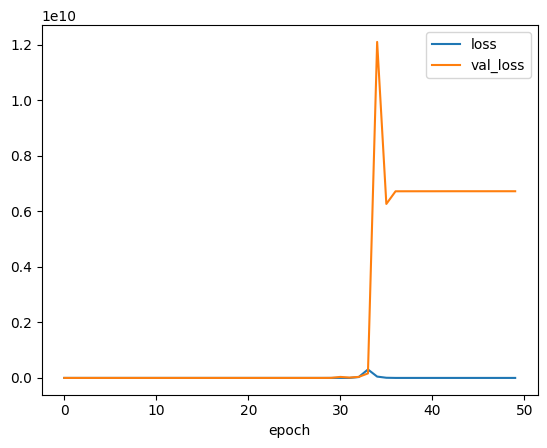

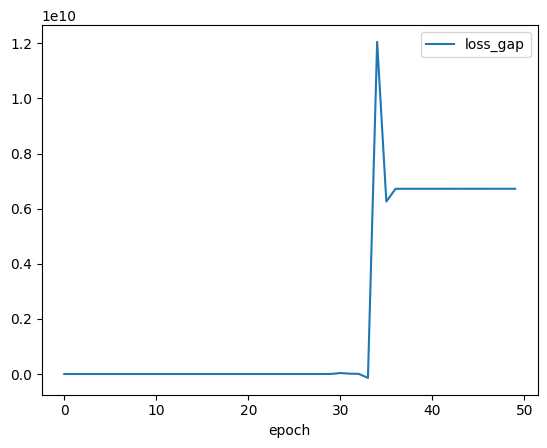

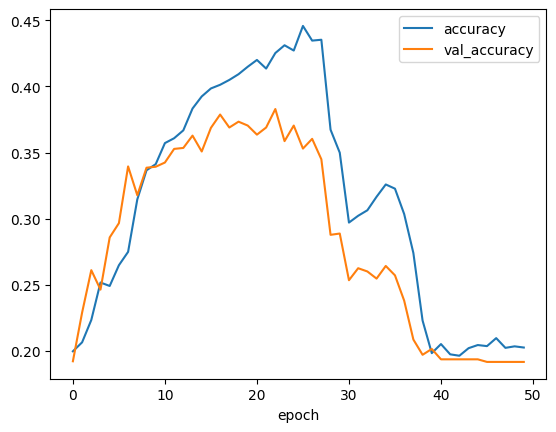

In [30]:
plot_experiment_results(df_results, "1")

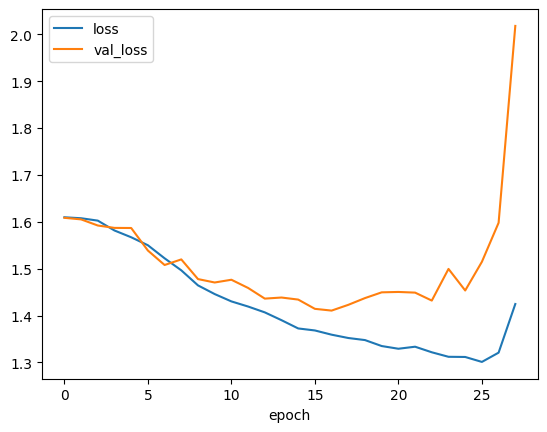

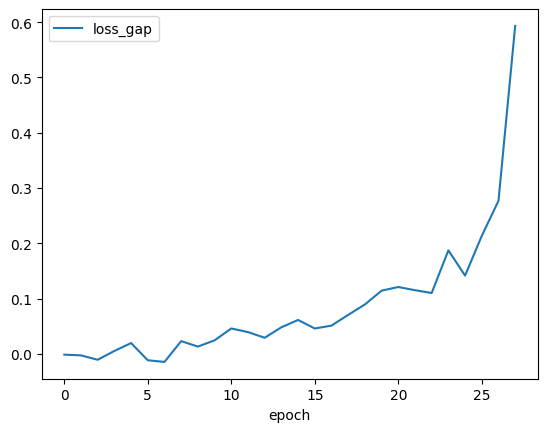

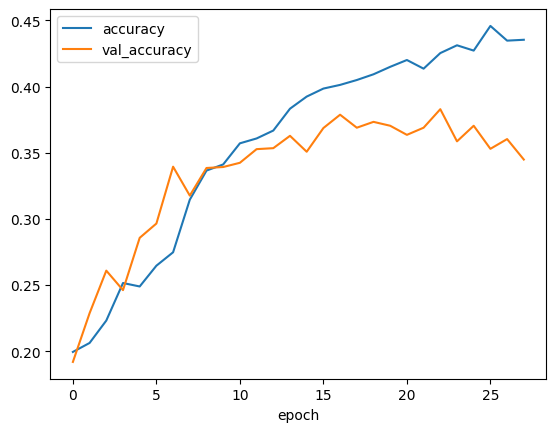

In [31]:
plot_experiment_results(df_results, "1", 27)

In [32]:
ES = False
BATCH_SIZE = 128
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("2", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50
32/32 [==============================] - 20s 329ms/step - loss: 1.6092 - accuracy: 0.2073 - val_loss: 1.6093 - val_accuracy: 0.2069
Epoch 2/50
32/32 [==============================] - 3s 104ms/step - loss: 1.6088 - accuracy: 0.1987 - val_loss: 1.6091 - val_accuracy: 0.2077
Epoch 3/50
32/32 [==============================] - 3s 104ms/step - loss: 1.6081 - accuracy: 0.2085 - val_loss: 1.6072 - val_accuracy: 0.2091
Epoch 4/50
32/32 [==============================] - 3s 105ms/step - loss: 1.6054 - accuracy: 0.2109 - val_loss: 1.6051 - val_accuracy: 0.2209
Epoch 5/50
32/32 [==============================] - 3s 105ms/step - loss: 1.6037 - accuracy: 0.2227 - val_loss: 1.5986 - val_accuracy: 0.2467
Epoch 6/50
32/32 [==============================] - 3s 105ms/step - loss: 1.6026 - accuracy: 0.2288 - val_loss: 1.5995 - val_accuracy: 0.2636
Epoch 7/50
32/32 [========================

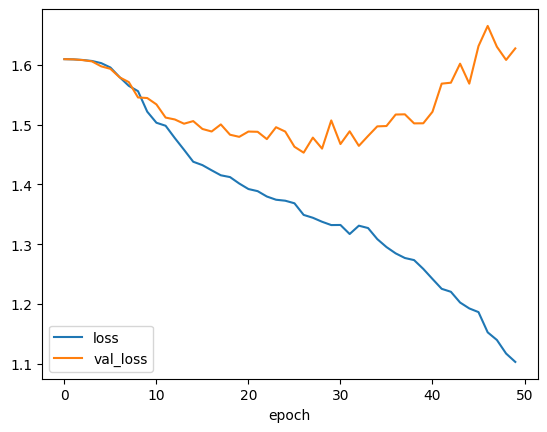

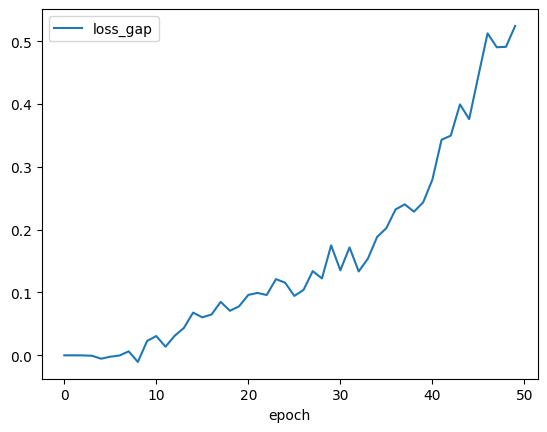

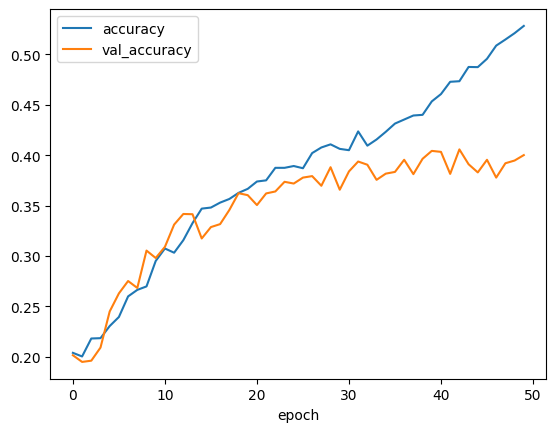

In [33]:
plot_experiment_results(df_results, "2")

In [34]:
plot_experiments_comp(df_results, ["1","2"], "val_loss", 27)

TypeError: plot_experiments_comp() missing 1 required positional argument: 'y_dim'

In [35]:
ES = False
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("3", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50
21/21 [==============================] - 25s 603ms/step - loss: 1.6089 - accuracy: 0.2078 - val_loss: 1.6092 - val_accuracy: 0.2209
Epoch 2/50
21/21 [==============================] - 3s 157ms/step - loss: 1.6089 - accuracy: 0.2024 - val_loss: 1.6086 - val_accuracy: 0.2187
Epoch 3/50
21/21 [==============================] - 3s 158ms/step - loss: 1.6084 - accuracy: 0.2041 - val_loss: 1.6080 - val_accuracy: 0.2032
Epoch 4/50
21/21 [==============================] - 3s 158ms/step - loss: 1.6069 - accuracy: 0.2122 - val_loss: 1.6072 - val_accuracy: 0.2069
Epoch 5/50
21/21 [==============================] - 3s 157ms/step - loss: 1.6052 - accuracy: 0.2168 - val_loss: 1.6055 - val_accuracy: 0.2312
Epoch 6/50
21/21 [==============================] - 3s 157ms/step - loss: 1.6038 - accuracy: 0.2217 - val_loss: 1.6014 - val_accuracy: 0.2474
Epoch 7/50
21/21 [========================

In [ ]:
plot_experiments_comp(df_results, ["1","2", "3"], "val_accuracy")

In [ ]:
plot_experiments_comp(df_results, ["1","2", "3"], "val_loss", 21)

In [36]:
ES = False
BATCH_SIZE = 256
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("4", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Epoch 1/50
16/16 [==============================] - 28s 823ms/step - loss: 1.6095 - accuracy: 0.2046 - val_loss: 1.6096 - val_accuracy: 0.1988
Epoch 2/50
16/16 [==============================] - 3s 199ms/step - loss: 1.6094 - accuracy: 0.2016 - val_loss: 1.6096 - val_accuracy: 0.2268
Epoch 3/50
16/16 [==============================] - 3s 199ms/step - loss: 1.6092 - accuracy: 0.2102 - val_loss: 1.6096 - val_accuracy: 0.2187
Epoch 4/50
16/16 [==============================] - 3s 199ms/step - loss: 1.6089 - accuracy: 0.2092 - val_loss: 1.6095 - val_accuracy: 0.2135
Epoch 5/50
16/16 [==============================] - 3s 199ms/step - loss: 1.6090 - accuracy: 0.2065 - val_loss: 1.6095 - val_accuracy: 0.2084
Epoch 6/50
16/16 [==============================] - 3s 198ms/step - loss: 1.6087 - accuracy: 0.2129 - val_loss: 1.6092 - val_accuracy: 0.2032
Epoch 7/50
16/16 [========================

In [ ]:
plot_experiments_comp(df_results, ["1","2","3","4"], "val_loss", 21)

In [ ]:
plot_experiments_comp(df_results, ["1","2","3","4"], "val_accuracy")

In [ ]:
plot_experiments_comp(df_results, ["1","2","3","4"], "loss_gap", 21)

In [37]:
df_results.to_csv(WORKING_DATA / "results.csv")

Batch size of between 196-256 seems optimal, certainly moreso than 64, whereas the model descends into a very bad state from epoch 20 onwards.  Using a batch size of 196 should give a good baseline against which to experiment further.

### Baseline Model

In [ ]:
df_results = pd.DataFrame

In [38]:
ES = True
BATCH_SIZE = 196
ds_train, ds_valid = get_equal_split_dataset(dataset_path)
(m, df_hist) = run_experiment("baseline", 1, create_simple_model, ds_train, ds_valid)
df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 11s 237ms/step - loss: 1.6095 - accuracy: 0.1977 - val_loss: 1.6093 - val_accuracy: 0.2084
Epoch 2/50
21/21 [==============================] - 3s 158ms/step - loss: 1.6084 - accuracy: 0.2070 - val_loss: 1.6089 - val_accuracy: 0.2150
Epoch 3/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6084 - accuracy: 0.2095 - val_loss: 1.6082 - val_accuracy: 0.2099
Epoch 4/50
21/21 [==============================] - 3s 158ms/step - loss: 1.6076 - accuracy: 0.2198 - val_loss: 1.6070 - val_accuracy: 0.2246
Epoch 5/50
21/21 [==============================] - 3s 158ms/step - loss: 1.6048 - accuracy: 0.2335 - val_loss: 1.6043 - val_accuracy: 0.2290
Epoch 6/50
21/21 [==============================] - 3s 159ms/step - loss: 1.6020 - accuracy: 0.2499 - val_loss: 1.5978 - val_accuracy: 0.2489
Epoch 7/50
21/21 [====

In [39]:
m.evaluate(ds_valid)

7/7 [==============================] - 0s 45ms/step - loss: 1.3662 - accuracy: 0.4161


[1.3661786317825317, 0.41605302691459656]

In [40]:
probabilities = m.predict(ds_valid)
predictions = np.argmax(probabilities, axis=-1)
Counter(predictions)

7/7 [==============================] - 0s 43ms/step


Counter({3: 417, 0: 327, 4: 221, 1: 220, 2: 173})

In [41]:
print(len(probabilities))
print(probabilities[0])
print(predictions[0])
print(probabilities[1])
print(predictions[1])

1358
[0.14051847 0.35233563 0.1451873  0.06787492 0.29408363]
1
[0.05382607 0.04885529 0.285494   0.42886627 0.18295835]
3


In [60]:
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline_rep", i, create_simple_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 11s 235ms/step - loss: 1.6099 - accuracy: 0.2006 - val_loss: 1.6093 - val_accuracy: 0.2047
Epoch 2/50
21/21 [==============================] - 3s 161ms/step - loss: 1.6092 - accuracy: 0.2043 - val_loss: 1.6090 - val_accuracy: 0.2239
Epoch 3/50
21/21 [==============================] - 3s 160ms/step - loss: 1.6082 - accuracy: 0.2097 - val_loss: 1.6087 - val_accuracy: 0.2209
Epoch 4/50
21/21 [==============================] - 3s 160ms/step - loss: 1.6084 - accuracy: 0.2014 - val_loss: 1.6081 - val_accuracy: 0.2047
Epoch 5/50
21/21 [==============================] - 3s 160ms/step - loss: 1.6071 - accuracy: 0.2119 - val_loss: 1.6072 - val_accuracy: 0.2224
Epoch 6/50
21/21 [==============================] - 3s 160ms/step - loss: 1.6060 - accuracy: 0.2188 - val_loss: 1.6053 - val_accuracy: 0.2297
Epoch 7/50
21/21 [====

In [62]:
df_results.to_csv(WORKING_DATA / "results.csv")

In [42]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [43]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline+bn", i, create_simple_model_bn, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 11s 233ms/step - loss: 1.6032 - accuracy: 0.2274 - val_loss: 1.6090 - val_accuracy: 0.1988
Epoch 2/50
21/21 [==============================] - 3s 159ms/step - loss: 1.5629 - accuracy: 0.2708 - val_loss: 1.6070 - val_accuracy: 0.2047
Epoch 3/50
21/21 [==============================] - 3s 158ms/step - loss: 1.5273 - accuracy: 0.2840 - val_loss: 1.6037 - val_accuracy: 0.2297
Epoch 4/50
21/21 [==============================] - 3s 159ms/step - loss: 1.5025 - accuracy: 0.3091 - val_loss: 1.5976 - val_accuracy: 0.2577
Epoch 5/50
21/21 [==============================] - 3s 159ms/step - loss: 1.4788 - accuracy: 0.3245 - val_loss: 1.5936 - val_accuracy: 0.3159
Epoch 6/50
21/21 [==============================] - 3s 159ms/step - loss: 1.4460 - accuracy: 0.3495 - val_loss: 1.5807 - val_accuracy: 0.3277
Epoch 7/50
21/21 [====

In [44]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn2() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [45]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline+bn2", i, create_simple_model_bn2, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 12s 258ms/step - loss: 1.6099 - accuracy: 0.2021 - val_loss: 1.6089 - val_accuracy: 0.1981
Epoch 2/50
21/21 [==============================] - 4s 174ms/step - loss: 1.6063 - accuracy: 0.2239 - val_loss: 1.6076 - val_accuracy: 0.1996
Epoch 3/50
21/21 [==============================] - 4s 174ms/step - loss: 1.6004 - accuracy: 0.2423 - val_loss: 1.6035 - val_accuracy: 0.2261
Epoch 4/50
21/21 [==============================] - 4s 173ms/step - loss: 1.5842 - accuracy: 0.2693 - val_loss: 1.5852 - val_accuracy: 0.2828
Epoch 5/50
21/21 [==============================] - 4s 174ms/step - loss: 1.5441 - accuracy: 0.2806 - val_loss: 1.5449 - val_accuracy: 0.3071
Epoch 6/50
21/21 [==============================] - 4s 174ms/step - loss: 1.5117 - accuracy: 0.2943 - val_loss: 1.5373 - val_accuracy: 0.3137
Epoch 7/50
21/21 [====

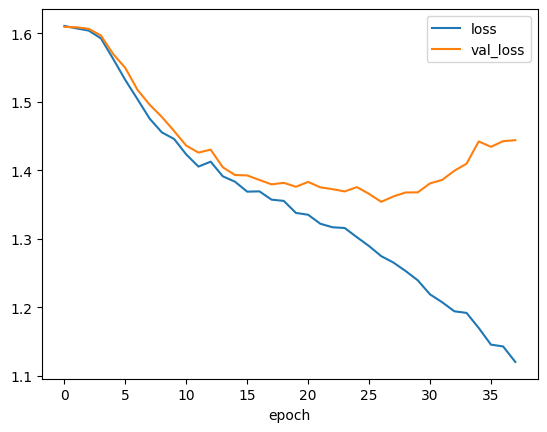

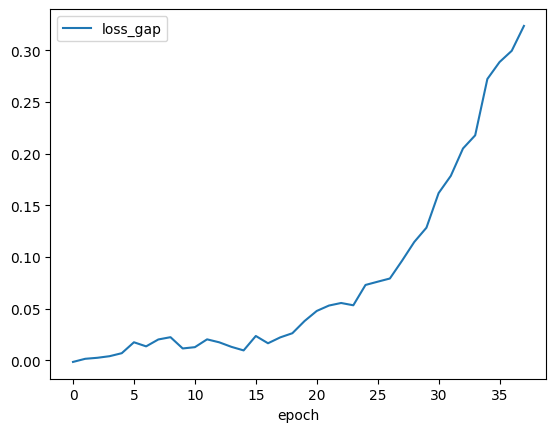

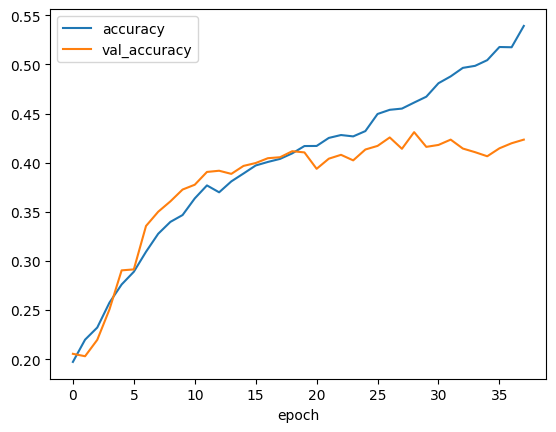

In [52]:
plot_experiment_results(df_results, "baseline+bn2")

In [56]:
df_results.to_csv(WORKING_DATA / "results.csv")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

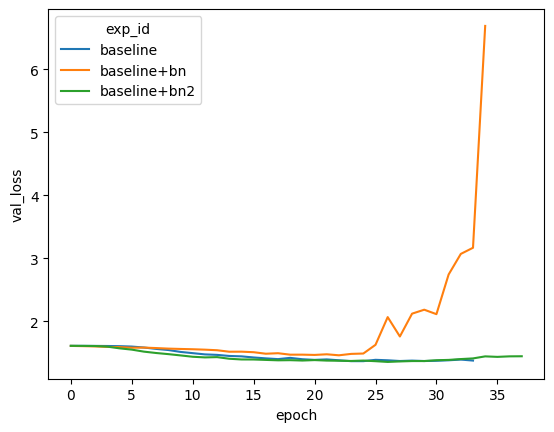

In [48]:
plot_experiments_comp(df_results, ["baseline","baseline+bn", "baseline+bn2"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

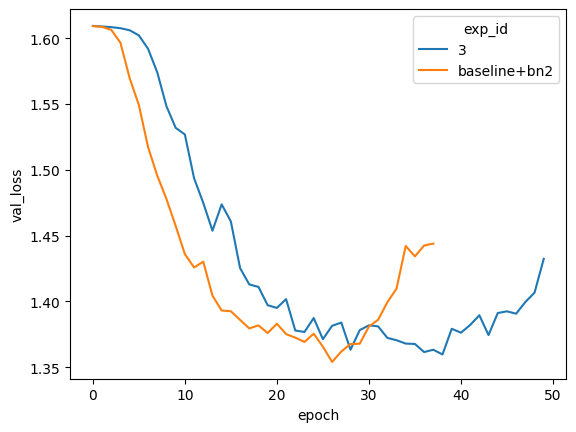

In [53]:
plot_experiments_comp(df_results, ["3", "baseline+bn2"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

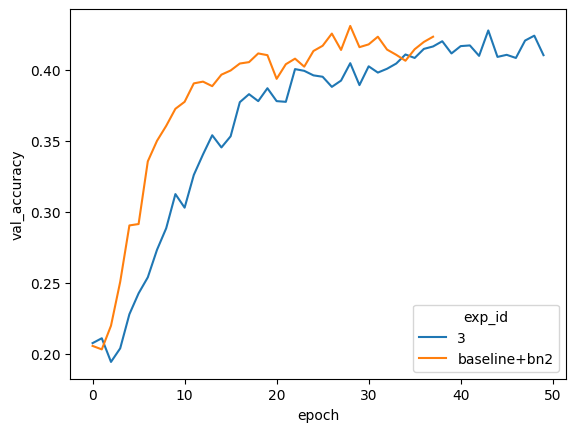

In [64]:
plot_experiments_comp(df_results, ["3", "baseline+bn2"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

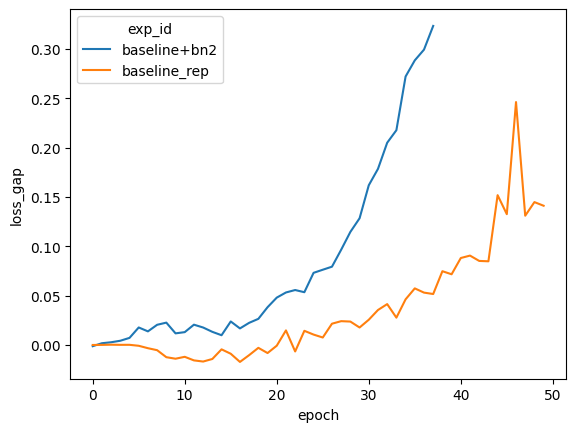

In [63]:
plot_experiments_comp(df_results, ["baseline_rep", "baseline+bn2"], "loss_gap")

In [58]:
df_results2 = df_results.copy()

In [59]:
print(len(df_results))
df_results = df_results[df_results.exp_id!="baseline"].copy()
print(len(df_results))

846
812


In [65]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn3() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [66]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline+bn3", i, create_simple_model_bn3, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 12s 253ms/step - loss: 1.6098 - accuracy: 0.2011 - val_loss: 1.6095 - val_accuracy: 0.2106
Epoch 2/50
21/21 [==============================] - 4s 173ms/step - loss: 1.6079 - accuracy: 0.2163 - val_loss: 1.6094 - val_accuracy: 0.1937
Epoch 3/50
21/21 [==============================] - 4s 177ms/step - loss: 1.6067 - accuracy: 0.2234 - val_loss: 1.6090 - val_accuracy: 0.1900
Epoch 4/50
21/21 [==============================] - 4s 177ms/step - loss: 1.6030 - accuracy: 0.2416 - val_loss: 1.6070 - val_accuracy: 0.2040
Epoch 5/50
21/21 [==============================] - 4s 177ms/step - loss: 1.5938 - accuracy: 0.2593 - val_loss: 1.5979 - val_accuracy: 0.2297
Epoch 6/50
21/21 [==============================] - 4s 177ms/step - loss: 1.5508 - accuracy: 0.2872 - val_loss: 1.5485 - val_accuracy: 0.3203
Epoch 7/50
21/21 [====

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

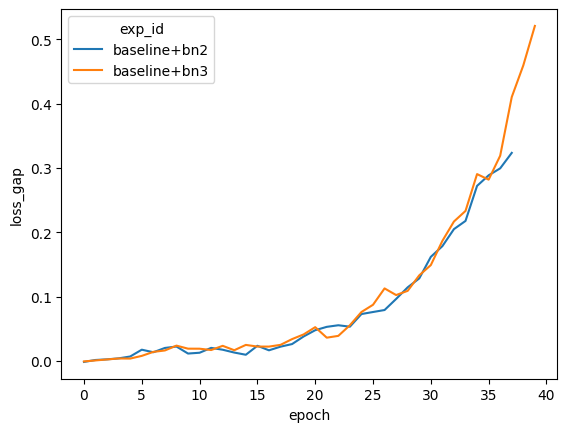

In [71]:
plot_experiments_comp(df_results, ["baseline+bn2", "baseline+bn3"], "loss_gap")

In [79]:
df_results.to_csv(WORKING_DATA / "results.csv")

In [73]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn4() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(2048, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(2048, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [74]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline+bn4", i, create_simple_model_bn4, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 12s 268ms/step - loss: 1.6102 - accuracy: 0.1921 - val_loss: 1.6095 - val_accuracy: 0.1996
Epoch 2/50
21/21 [==============================] - 4s 185ms/step - loss: 1.6085 - accuracy: 0.2068 - val_loss: 1.6091 - val_accuracy: 0.2025
Epoch 3/50
21/21 [==============================] - 4s 185ms/step - loss: 1.6078 - accuracy: 0.2183 - val_loss: 1.6085 - val_accuracy: 0.1937
Epoch 4/50
21/21 [==============================] - 4s 185ms/step - loss: 1.6045 - accuracy: 0.2458 - val_loss: 1.6069 - val_accuracy: 0.1929
Epoch 5/50
21/21 [==============================] - 4s 185ms/step - loss: 1.5968 - accuracy: 0.2698 - val_loss: 1.5991 - val_accuracy: 0.2459
Epoch 6/50
21/21 [==============================] - 4s 185ms/step - loss: 1.5665 - accuracy: 0.2774 - val_loss: 1.5535 - val_accuracy: 0.2982
Epoch 7/50
21/21 [====

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

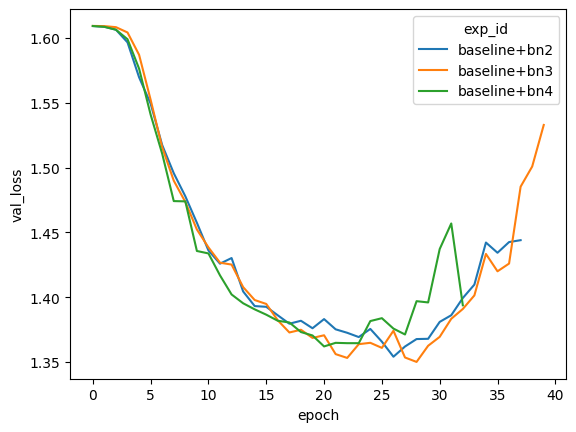

In [75]:
plot_experiments_comp(df_results, ["baseline+bn2", "baseline+bn3", "baseline+bn4"], "val_loss")

In [76]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn5() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        #layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [77]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline+bn5", i, create_simple_model_bn5, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
21/21 [==============================] - 11s 244ms/step - loss: 1.6101 - accuracy: 0.2028 - val_loss: 1.6094 - val_accuracy: 0.1981
Epoch 2/50
21/21 [==============================] - 4s 171ms/step - loss: 1.6072 - accuracy: 0.2109 - val_loss: 1.6090 - val_accuracy: 0.2246
Epoch 3/50
21/21 [==============================] - 4s 171ms/step - loss: 1.6042 - accuracy: 0.2406 - val_loss: 1.6070 - val_accuracy: 0.2349
Epoch 4/50
21/21 [==============================] - 4s 171ms/step - loss: 1.5904 - accuracy: 0.2669 - val_loss: 1.5971 - val_accuracy: 0.2533
Epoch 5/50
21/21 [==============================] - 4s 171ms/step - loss: 1.5663 - accuracy: 0.2688 - val_loss: 1.5752 - val_accuracy: 0.2953
Epoch 6/50
21/21 [==============================] - 4s 171ms/step - loss: 1.5416 - accuracy: 0.2831 - val_loss: 1.5547 - val_accuracy: 0.2806
Epoch 7/50
21/21 [====

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

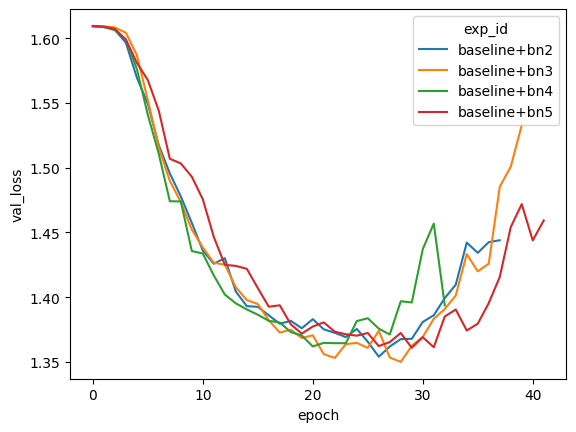

In [78]:
plot_experiments_comp(df_results, ["baseline+bn2", "baseline+bn3", "baseline+bn4", "baseline+bn5"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

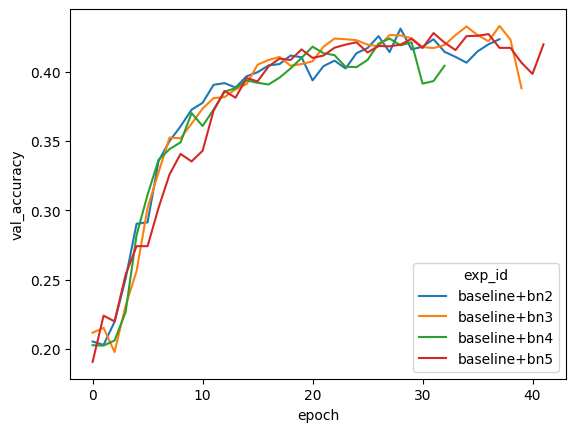

In [80]:
plot_experiments_comp(df_results, ["baseline+bn2", "baseline+bn3", "baseline+bn4", "baseline+bn5"], "val_accuracy")

In [81]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn_do() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [82]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline+bn+do", i, create_simple_model_bn_do, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


2024-02-28 20:11:41.982728: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_31/dropout_62/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 12s 299ms/step - loss: 1.6144 - accuracy: 0.1984 - val_loss: 1.6098 - val_accuracy: 0.1937
Epoch 2/50
21/21 [==============================] - 5s 222ms/step - loss: 1.6098 - accuracy: 0.2075 - val_loss: 1.6097 - val_accuracy: 0.1915
Epoch 3/50
21/21 [==============================] - 5s 223ms/step - loss: 1.6097 - accuracy: 0.1977 - val_loss: 1.6096 - val_accuracy: 0.1885
Epoch 4/50
21/21 [==============================] - 5s 223ms/step - loss: 1.6080 - accuracy: 0.2151 - val_loss: 1.6095 - val_accuracy: 0.1885
Epoch 5/50
21/21 [==============================] - 5s 224ms/step - loss: 1.6071 - accuracy: 0.2131 - val_loss: 1.6087 - val_accuracy: 0.1900
Epoch 6/50
21/21 [==============================] - 5s 223ms/step - loss: 1.6040 - accuracy: 0.2217 - val_loss: 1.6056 - val_accuracy: 0.2437
Epoch 7/50
21/21 [==============================] - 5s 223ms/step - loss: 1.5895 - accuracy: 0.2615 - val_loss: 1.5909 - val_accuracy: 0.2577
Epoch 8/50
21/21

2024-02-28 20:15:06.318627: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_32/dropout_68/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 12s 298ms/step - loss: 1.6121 - accuracy: 0.2078 - val_loss: 1.6094 - val_accuracy: 0.1966
Epoch 2/50
21/21 [==============================] - 5s 223ms/step - loss: 1.6093 - accuracy: 0.2124 - val_loss: 1.6090 - val_accuracy: 0.1944
Epoch 3/50
21/21 [==============================] - 5s 223ms/step - loss: 1.6053 - accuracy: 0.2244 - val_loss: 1.6071 - val_accuracy: 0.2408
Epoch 4/50
21/21 [==============================] - 5s 223ms/step - loss: 1.5940 - accuracy: 0.2497 - val_loss: 1.5992 - val_accuracy: 0.2496
Epoch 5/50
21/21 [==============================] - 5s 223ms/step - loss: 1.5642 - accuracy: 0.2683 - val_loss: 1.5722 - val_accuracy: 0.2828
Epoch 6/50
21/21 [==============================] - 5s 223ms/step - loss: 1.5187 - accuracy: 0.2975 - val_loss: 1.5437 - val_accuracy: 0.3078
Epoch 7/50
21/21 [==============================] - 5s 223ms/step - loss: 1.4924 - accuracy: 0.3100 - val_loss: 1.5280 - val_accuracy: 0.3189
Epoch 8/50
21/21

2024-02-28 20:18:39.095161: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_33/dropout_74/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 12s 300ms/step - loss: 1.6119 - accuracy: 0.1972 - val_loss: 1.6097 - val_accuracy: 0.1915
Epoch 2/50
21/21 [==============================] - 5s 221ms/step - loss: 1.6104 - accuracy: 0.1928 - val_loss: 1.6097 - val_accuracy: 0.1907
Epoch 3/50
21/21 [==============================] - 5s 223ms/step - loss: 1.6067 - accuracy: 0.2249 - val_loss: 1.6096 - val_accuracy: 0.1885
Epoch 4/50
21/21 [==============================] - 5s 223ms/step - loss: 1.6073 - accuracy: 0.2161 - val_loss: 1.6087 - val_accuracy: 0.1944
Epoch 5/50
21/21 [==============================] - 5s 223ms/step - loss: 1.5983 - accuracy: 0.2477 - val_loss: 1.6039 - val_accuracy: 0.2378
Epoch 6/50
21/21 [==============================] - 5s 223ms/step - loss: 1.5672 - accuracy: 0.2686 - val_loss: 1.5694 - val_accuracy: 0.2806
Epoch 7/50
21/21 [==============================] - 5s 223ms/step - loss: 1.5191 - accuracy: 0.2951 - val_loss: 1.5460 - val_accuracy: 0.3085
Epoch 8/50
21/21

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

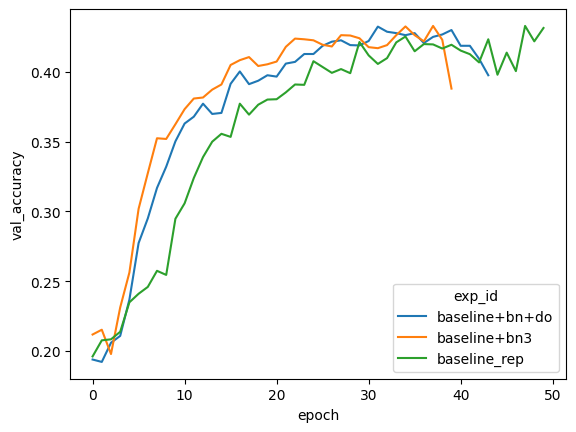

In [83]:
plot_experiments_comp(df_results, ["baseline_rep", "baseline+bn3", "baseline+bn+do"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

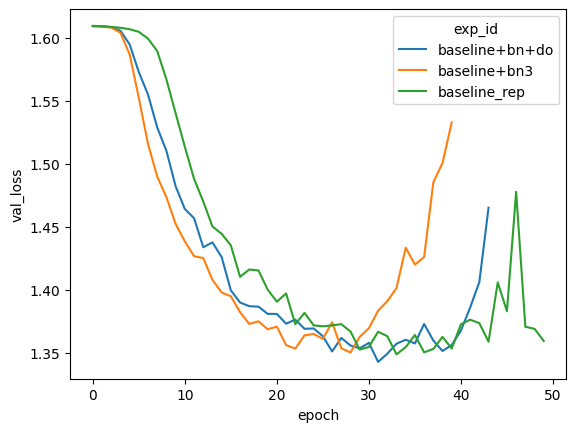

In [85]:
plot_experiments_comp(df_results, ["baseline_rep", "baseline+bn3", "baseline+bn+do"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

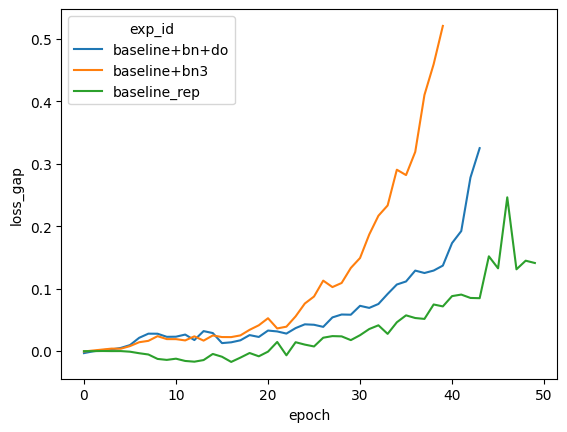

In [86]:
plot_experiments_comp(df_results, ["baseline_rep", "baseline+bn3", "baseline+bn+do"], "loss_gap")

In [88]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn_do_3l() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [89]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline+bn+do-3L", i, create_simple_model_bn_do_3l, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


2024-02-28 20:33:20.291312: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_34/dropout_80/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 12s 289ms/step - loss: 1.6241 - accuracy: 0.2011 - val_loss: 1.6083 - val_accuracy: 0.1885
Epoch 2/50
21/21 [==============================] - 4s 203ms/step - loss: 1.6032 - accuracy: 0.2291 - val_loss: 1.6052 - val_accuracy: 0.2231
Epoch 3/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5773 - accuracy: 0.2548 - val_loss: 1.5864 - val_accuracy: 0.2548
Epoch 4/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5313 - accuracy: 0.2924 - val_loss: 1.5773 - val_accuracy: 0.2629
Epoch 5/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5013 - accuracy: 0.3113 - val_loss: 1.5363 - val_accuracy: 0.3159
Epoch 6/50
21/21 [==============================] - 4s 203ms/step - loss: 1.4715 - accuracy: 0.3284 - val_loss: 1.5104 - val_accuracy: 0.3351
Epoch 7/50
21/21 [==============================] - 4s 204ms/step - loss: 1.4617 - accuracy: 0.3380 - val_loss: 1.4983 - val_accuracy: 0.3601
Epoch 8/50
21/21

2024-02-28 20:35:33.881674: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_35/dropout_85/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 11s 284ms/step - loss: 1.6391 - accuracy: 0.1945 - val_loss: 1.6086 - val_accuracy: 0.1900
Epoch 2/50
21/21 [==============================] - 4s 203ms/step - loss: 1.6015 - accuracy: 0.2362 - val_loss: 1.6082 - val_accuracy: 0.2018
Epoch 3/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5850 - accuracy: 0.2487 - val_loss: 1.6058 - val_accuracy: 0.1988
Epoch 4/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5665 - accuracy: 0.2705 - val_loss: 1.5930 - val_accuracy: 0.2916
Epoch 5/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5453 - accuracy: 0.2882 - val_loss: 1.5771 - val_accuracy: 0.2879
Epoch 6/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5061 - accuracy: 0.3091 - val_loss: 1.5428 - val_accuracy: 0.3211
Epoch 7/50
21/21 [==============================] - 4s 203ms/step - loss: 1.4756 - accuracy: 0.3311 - val_loss: 1.5177 - val_accuracy: 0.3520
Epoch 8/50
21/21

2024-02-28 20:37:47.012160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_36/dropout_90/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 11s 285ms/step - loss: 1.6215 - accuracy: 0.2001 - val_loss: 1.6089 - val_accuracy: 0.2047
Epoch 2/50
21/21 [==============================] - 4s 203ms/step - loss: 1.6030 - accuracy: 0.2276 - val_loss: 1.6079 - val_accuracy: 0.2040
Epoch 3/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5785 - accuracy: 0.2487 - val_loss: 1.6050 - val_accuracy: 0.2106
Epoch 4/50
21/21 [==============================] - 4s 204ms/step - loss: 1.5580 - accuracy: 0.2796 - val_loss: 1.5914 - val_accuracy: 0.2784
Epoch 5/50
21/21 [==============================] - 4s 203ms/step - loss: 1.5221 - accuracy: 0.2970 - val_loss: 1.5632 - val_accuracy: 0.2887
Epoch 6/50
21/21 [==============================] - 4s 203ms/step - loss: 1.4827 - accuracy: 0.3218 - val_loss: 1.5232 - val_accuracy: 0.3417
Epoch 7/50
21/21 [==============================] - 4s 203ms/step - loss: 1.4501 - accuracy: 0.3532 - val_loss: 1.4961 - val_accuracy: 0.3630
Epoch 8/50
21/21

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

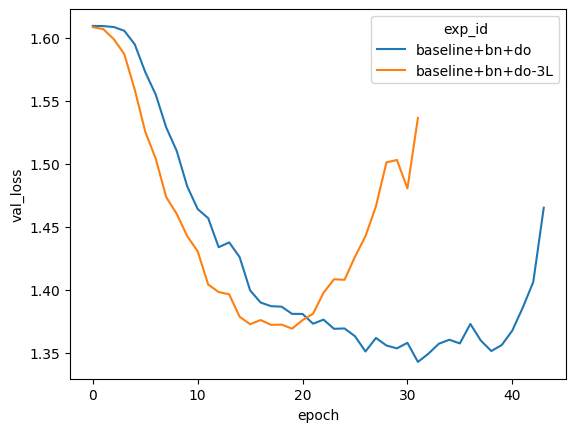

In [91]:
plot_experiments_comp(df_results, ["baseline+bn+do", "baseline+bn+do-3L"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

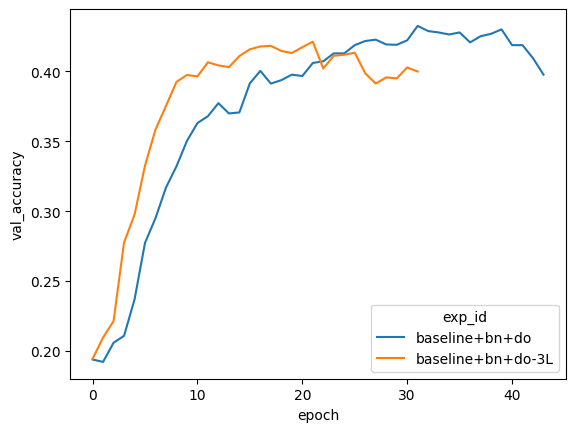

In [92]:
plot_experiments_comp(df_results, ["baseline+bn+do", "baseline+bn+do-3L"], "val_accuracy")

In [15]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def create_simple_model_bn_do_5l() -> Model:
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        # First Convolutional Block
        layers.Conv2D(filters=32, kernel_size=5, activation="relu", padding='same'),
        layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Second Convolutional Block
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Third Convolutional Block
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),
        
        # Fourth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),
        
        # Fifth Convolutional Block
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding='same'),
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [95]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_dataset(dataset_path)
    (m, df_hist) = run_experiment("baseline+bn+do-5L", i, create_simple_model_bn_do_5l, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


2024-02-28 20:43:57.266193: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_37/dropout_95/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 14s 318ms/step - loss: 1.6119 - accuracy: 0.1928 - val_loss: 1.6095 - val_accuracy: 0.1944
Epoch 2/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6105 - accuracy: 0.1930 - val_loss: 1.6095 - val_accuracy: 0.1981
Epoch 3/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6093 - accuracy: 0.2085 - val_loss: 1.6096 - val_accuracy: 0.1944
Epoch 4/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6095 - accuracy: 0.2070 - val_loss: 1.6095 - val_accuracy: 0.1944
Epoch 5/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6094 - accuracy: 0.2068 - val_loss: 1.6094 - val_accuracy: 0.1944
Epoch 6/50
21/21 [==============================] - 5s 229ms/step - loss: 1.6091 - accuracy: 0.2109 - val_loss: 1.6094 - val_accuracy: 0.1944
Epoch 7/50
21/21 [==============================] - 5s 229ms/step - loss: 1.6080 - accuracy: 0.2117 - val_loss: 1.6090 - val_accuracy: 0.1966
Epoch 8/50
21/21

2024-02-28 20:48:06.233249: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_38/dropout_102/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 13s 305ms/step - loss: 1.6090 - accuracy: 0.2119 - val_loss: 1.6093 - val_accuracy: 0.2010
Epoch 2/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6101 - accuracy: 0.1955 - val_loss: 1.6094 - val_accuracy: 0.1848
Epoch 3/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6096 - accuracy: 0.2019 - val_loss: 1.6094 - val_accuracy: 0.1856
Epoch 4/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6101 - accuracy: 0.1962 - val_loss: 1.6094 - val_accuracy: 0.1937
Epoch 5/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6083 - accuracy: 0.2117 - val_loss: 1.6093 - val_accuracy: 0.1856
Epoch 6/50
21/21 [==============================] - 5s 229ms/step - loss: 1.6067 - accuracy: 0.2114 - val_loss: 1.6085 - val_accuracy: 0.1915
Epoch 7/50
21/21 [==============================] - 5s 229ms/step - loss: 1.6059 - accuracy: 0.2139 - val_loss: 1.6073 - val_accuracy: 0.2025
Epoch 8/50
21/21

2024-02-28 20:52:14.473053: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_39/dropout_109/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


21/21 [==============================] - 14s 303ms/step - loss: 1.6098 - accuracy: 0.2075 - val_loss: 1.6095 - val_accuracy: 0.1951
Epoch 2/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6096 - accuracy: 0.2033 - val_loss: 1.6096 - val_accuracy: 0.1885
Epoch 3/50
21/21 [==============================] - 5s 227ms/step - loss: 1.6088 - accuracy: 0.2131 - val_loss: 1.6097 - val_accuracy: 0.1885
Epoch 4/50
21/21 [==============================] - 5s 227ms/step - loss: 1.6095 - accuracy: 0.1952 - val_loss: 1.6096 - val_accuracy: 0.1885
Epoch 5/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6093 - accuracy: 0.1994 - val_loss: 1.6097 - val_accuracy: 0.1885
Epoch 6/50
21/21 [==============================] - 5s 228ms/step - loss: 1.6091 - accuracy: 0.2154 - val_loss: 1.6097 - val_accuracy: 0.1885
Epoch 7/50
21/21 [==============================] - 5s 227ms/step - loss: 1.6090 - accuracy: 0.2041 - val_loss: 1.6095 - val_accuracy: 0.1885
Epoch 8/50
21/21

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

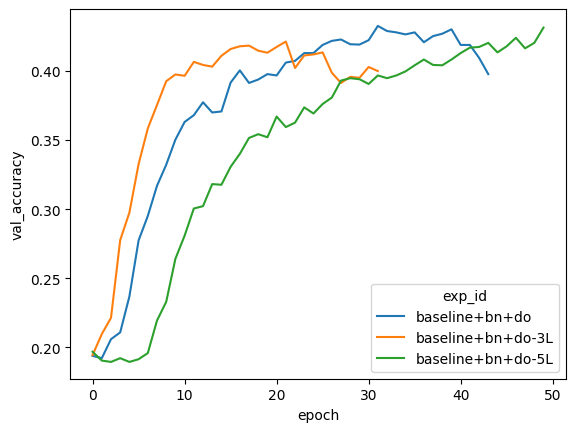

In [97]:
plot_experiments_comp(df_results, ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

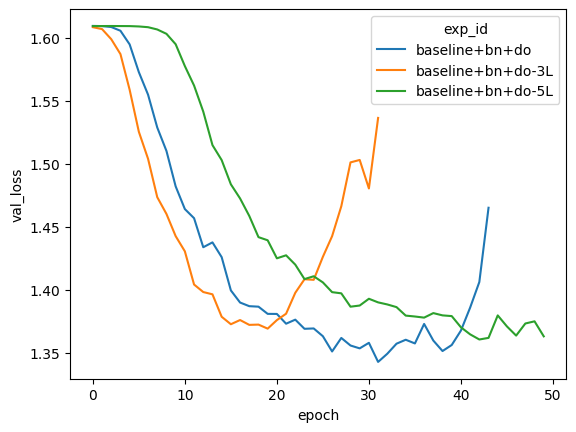

In [98]:
plot_experiments_comp(df_results, ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

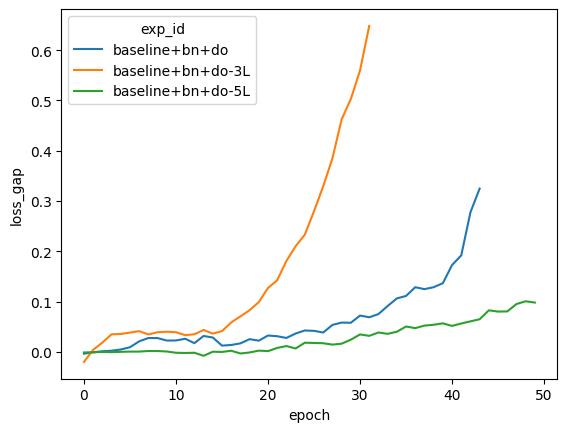

In [99]:
plot_experiments_comp(df_results, ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L"], "loss_gap")

In [100]:
df_results.to_csv(WORKING_DATA / "results.csv")

### Data Augmentation

In [13]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomFlip("vertical"),
        layers.RandomContrast(0.1),
        layers.RandomBrightness(0.1),
        layers.RandomRotation(0.1),
    ]
)

def get_equal_split_aug_dataset(path: Path, repeat: int):
    # Load dataset
    # categorical here means that the labels are one-hot encoded
    ds_train_, ds_valid_ = image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[120, 120],
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=VALIDATION_SPLIT,
        subset="both",
        seed=31415,
    )   

    # Data Pipeline
    def convert_to_float(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, 0.2)
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        image = image / 255.0
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .repeat(repeat)
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    return ds_train, ds_valid

In [103]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset(dataset_path, 4)
    (m, df_hist) = run_experiment("baseline+bn+do-5L-aug", i, create_simple_model_bn_do_5l, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
84/84 [==============================] - 34s 331ms/step - loss: 1.6095 - accuracy: 0.2011 - val_loss: 1.6097 - val_accuracy: 0.1885
Epoch 2/50
84/84 [==============================] - 18s 216ms/step - loss: 1.6090 - accuracy: 0.2102 - val_loss: 1.6094 - val_accuracy: 0.1885
Epoch 3/50
84/84 [==============================] - 18s 216ms/step - loss: 1.5796 - accuracy: 0.2538 - val_loss: 1.5476 - val_accuracy: 0.2747
Epoch 4/50
84/84 [==============================] - 18s 216ms/step - loss: 1.4904 - accuracy: 0.3068 - val_loss: 1.4801 - val_accuracy: 0.3461
Epoch 5/50
84/84 [==============================] - 18s 215ms/step - loss: 1.4491 - accuracy: 0.3419 - val_loss: 1.4311 - val_accuracy: 0.3623
Epoch 6/50
84/84 [==============================] - 18s 215ms/step - loss: 1.4120 - accuracy: 0.3650 - val_loss: 1.4279 - val_accuracy: 0.3630
Epoch 7/50
84/84 

2024-02-28 21:24:44.699802: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_43/dropout_130/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


84/84 [==============================] - 34s 329ms/step - loss: 1.6098 - accuracy: 0.1995 - val_loss: 1.6098 - val_accuracy: 0.1944
Epoch 2/50
84/84 [==============================] - 18s 216ms/step - loss: 1.6093 - accuracy: 0.1994 - val_loss: 1.6094 - val_accuracy: 0.1988
Epoch 3/50
84/84 [==============================] - 18s 216ms/step - loss: 1.6002 - accuracy: 0.2242 - val_loss: 1.5864 - val_accuracy: 0.2820
Epoch 4/50
84/84 [==============================] - 18s 216ms/step - loss: 1.5348 - accuracy: 0.2788 - val_loss: 1.5070 - val_accuracy: 0.3380
Epoch 5/50
84/84 [==============================] - 18s 216ms/step - loss: 1.4599 - accuracy: 0.3281 - val_loss: 1.4392 - val_accuracy: 0.3682
Epoch 6/50
84/84 [==============================] - 18s 215ms/step - loss: 1.4311 - accuracy: 0.3504 - val_loss: 1.4169 - val_accuracy: 0.3918
Epoch 7/50
84/84 [==============================] - 18s 215ms/step - loss: 1.4010 - accuracy: 0.3743 - val_loss: 1.4121 - val_accuracy: 0.3770
Epoch 8/50

2024-02-28 21:35:34.287345: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_44/dropout_137/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


84/84 [==============================] - 34s 332ms/step - loss: 1.6096 - accuracy: 0.2022 - val_loss: 1.6093 - val_accuracy: 0.1878
Epoch 2/50
84/84 [==============================] - 18s 216ms/step - loss: 1.6056 - accuracy: 0.2100 - val_loss: 1.6042 - val_accuracy: 0.2636
Epoch 3/50
84/84 [==============================] - 18s 216ms/step - loss: 1.5723 - accuracy: 0.2695 - val_loss: 1.5438 - val_accuracy: 0.3166
Epoch 4/50
84/84 [==============================] - 18s 215ms/step - loss: 1.5173 - accuracy: 0.2910 - val_loss: 1.4915 - val_accuracy: 0.3196
Epoch 5/50
84/84 [==============================] - 18s 215ms/step - loss: 1.4613 - accuracy: 0.3247 - val_loss: 1.4528 - val_accuracy: 0.3557
Epoch 6/50
84/84 [==============================] - 18s 215ms/step - loss: 1.4309 - accuracy: 0.3460 - val_loss: 1.4480 - val_accuracy: 0.3424
Epoch 7/50
84/84 [==============================] - 18s 216ms/step - loss: 1.4111 - accuracy: 0.3740 - val_loss: 1.4459 - val_accuracy: 0.3756
Epoch 8/50

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

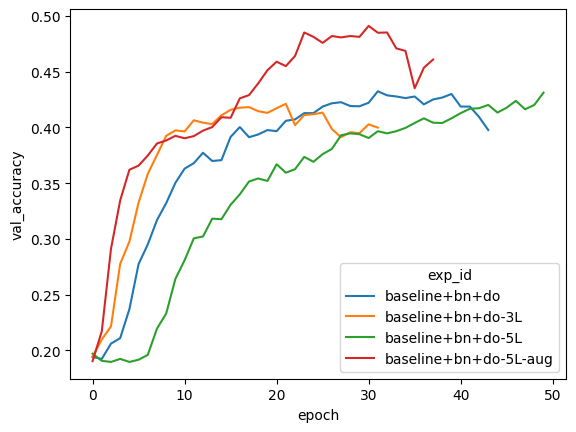

In [105]:
plot_experiments_comp(df_results, ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L", "baseline+bn+do-5L-aug"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

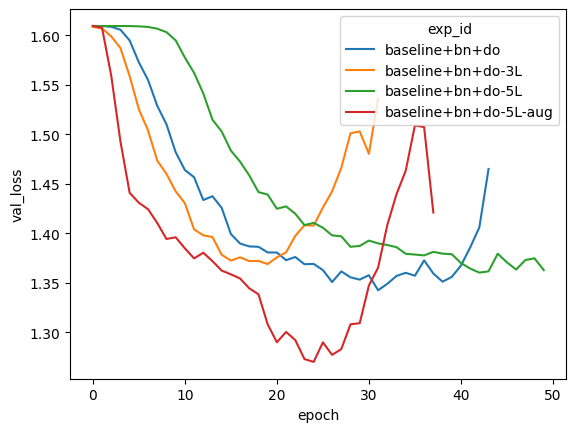

In [106]:
plot_experiments_comp(df_results, ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L", "baseline+bn+do-5L-aug"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

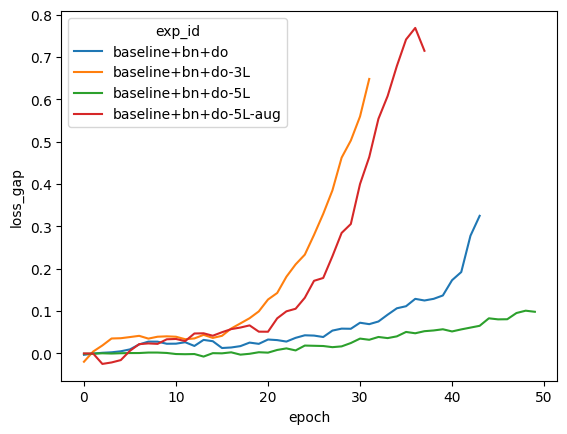

In [107]:
plot_experiments_comp(df_results, ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L", "baseline+bn+do-5L-aug"], "loss_gap")

In [109]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset(dataset_path, 2)
    (m, df_hist) = run_experiment("baseline+bn+do-5L-aug-sm", i, create_simple_model_bn_do_5l, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


2024-02-28 22:01:41.931187: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_46/dropout_144/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - 21s 349ms/step - loss: 1.6104 - accuracy: 0.1922 - val_loss: 1.6096 - val_accuracy: 0.1988
Epoch 2/50
42/42 [==============================] - 9s 219ms/step - loss: 1.6094 - accuracy: 0.2008 - val_loss: 1.6097 - val_accuracy: 0.1988
Epoch 3/50
42/42 [==============================] - 9s 219ms/step - loss: 1.6096 - accuracy: 0.2008 - val_loss: 1.6098 - val_accuracy: 0.1988
Epoch 4/50
42/42 [==============================] - 9s 220ms/step - loss: 1.6086 - accuracy: 0.2079 - val_loss: 1.6098 - val_accuracy: 0.1988
Epoch 5/50
42/42 [==============================] - 9s 220ms/step - loss: 1.6071 - accuracy: 0.2059 - val_loss: 1.6081 - val_accuracy: 0.2047
Epoch 6/50
42/42 [==============================] - 9s 220ms/step - loss: 1.5904 - accuracy: 0.2458 - val_loss: 1.5657 - val_accuracy: 0.2872
Epoch 7/50
42/42 [==============================] - 9s 220ms/step - loss: 1.5233 - accuracy: 0.2788 - val_loss: 1.5259 - val_accuracy: 0.3233
Epoch 8/50
42/42

2024-02-28 22:08:21.529624: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_47/dropout_151/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - 21s 339ms/step - loss: 1.6106 - accuracy: 0.1965 - val_loss: 1.6095 - val_accuracy: 0.1863
Epoch 2/50
42/42 [==============================] - 9s 220ms/step - loss: 1.6097 - accuracy: 0.1992 - val_loss: 1.6096 - val_accuracy: 0.1885
Epoch 3/50
42/42 [==============================] - 9s 219ms/step - loss: 1.6089 - accuracy: 0.2097 - val_loss: 1.6095 - val_accuracy: 0.1892
Epoch 4/50
42/42 [==============================] - 9s 220ms/step - loss: 1.6090 - accuracy: 0.2086 - val_loss: 1.6094 - val_accuracy: 0.1885
Epoch 5/50
42/42 [==============================] - 9s 220ms/step - loss: 1.6070 - accuracy: 0.2081 - val_loss: 1.6057 - val_accuracy: 0.2180
Epoch 6/50
42/42 [==============================] - 9s 220ms/step - loss: 1.5816 - accuracy: 0.2589 - val_loss: 1.5390 - val_accuracy: 0.3203
Epoch 7/50
42/42 [==============================] - 9s 220ms/step - loss: 1.5058 - accuracy: 0.2979 - val_loss: 1.4946 - val_accuracy: 0.3402
Epoch 8/50
42/42

2024-02-28 22:16:05.170569: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_48/dropout_158/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


42/42 [==============================] - 21s 342ms/step - loss: 1.6094 - accuracy: 0.2037 - val_loss: 1.6097 - val_accuracy: 0.2062
Epoch 2/50
42/42 [==============================] - 9s 219ms/step - loss: 1.6103 - accuracy: 0.2021 - val_loss: 1.6097 - val_accuracy: 0.2054
Epoch 3/50
42/42 [==============================] - 9s 219ms/step - loss: 1.6092 - accuracy: 0.2087 - val_loss: 1.6099 - val_accuracy: 0.1885
Epoch 4/50
42/42 [==============================] - 9s 219ms/step - loss: 1.6083 - accuracy: 0.2119 - val_loss: 1.6096 - val_accuracy: 0.1937
Epoch 5/50
42/42 [==============================] - 9s 220ms/step - loss: 1.6069 - accuracy: 0.2266 - val_loss: 1.6062 - val_accuracy: 0.2386
Epoch 6/50
42/42 [==============================] - 9s 220ms/step - loss: 1.5801 - accuracy: 0.2597 - val_loss: 1.5552 - val_accuracy: 0.2968
Epoch 7/50
42/42 [==============================] - 9s 220ms/step - loss: 1.5086 - accuracy: 0.2943 - val_loss: 1.4941 - val_accuracy: 0.3409
Epoch 8/50
42/42

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

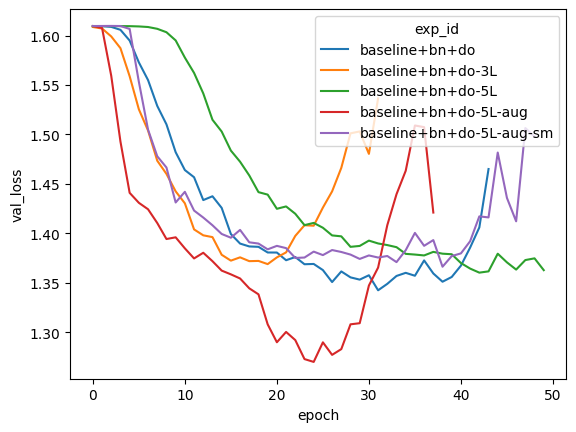

In [111]:
plot_experiments_comp(df_results,
      ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L", "baseline+bn+do-5L-aug", "baseline+bn+do-5L-aug-sm"],
                      "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

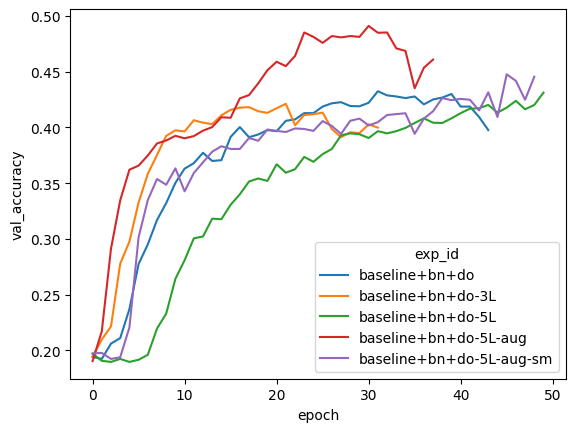

In [112]:
plot_experiments_comp(df_results,
      ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L", "baseline+bn+do-5L-aug", "baseline+bn+do-5L-aug-sm"],
                      "val_accuracy")

In [114]:
ES = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset(dataset_path, 8)
    (m, df_hist) = run_experiment("baseline+bn+do-5L-aug-lg", i, create_simple_model_bn_do_5l, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


2024-02-28 22:23:48.823313: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_49/dropout_165/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 61s 323ms/step - loss: 1.6095 - accuracy: 0.2054 - val_loss: 1.6095 - val_accuracy: 0.1885
Epoch 2/50
168/168 [==============================] - 36s 213ms/step - loss: 1.5945 - accuracy: 0.2256 - val_loss: 1.5435 - val_accuracy: 0.2798
Epoch 3/50
168/168 [==============================] - 36s 213ms/step - loss: 1.4756 - accuracy: 0.3152 - val_loss: 1.4267 - val_accuracy: 0.3645
Epoch 4/50
168/168 [==============================] - 36s 213ms/step - loss: 1.4055 - accuracy: 0.3698 - val_loss: 1.3978 - val_accuracy: 0.3866
Epoch 5/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3739 - accuracy: 0.3863 - val_loss: 1.3953 - val_accuracy: 0.3903
Epoch 6/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3597 - accuracy: 0.4012 - val_loss: 1.3933 - val_accuracy: 0.3903
Epoch 7/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3432 - accuracy: 0.4137 - val_loss: 1.3799 - val_accuracy: 0.3

2024-02-28 22:37:57.402560: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_50/dropout_172/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 60s 320ms/step - loss: 1.6063 - accuracy: 0.2099 - val_loss: 1.5982 - val_accuracy: 0.2879
Epoch 2/50
168/168 [==============================] - 36s 213ms/step - loss: 1.6025 - accuracy: 0.2154 - val_loss: 1.6085 - val_accuracy: 0.2077
Epoch 3/50
168/168 [==============================] - 36s 213ms/step - loss: 1.5389 - accuracy: 0.2726 - val_loss: 1.4561 - val_accuracy: 0.3557
Epoch 4/50
168/168 [==============================] - 36s 213ms/step - loss: 1.4261 - accuracy: 0.3577 - val_loss: 1.4216 - val_accuracy: 0.3785
Epoch 5/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3814 - accuracy: 0.3832 - val_loss: 1.4165 - val_accuracy: 0.3859
Epoch 6/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3622 - accuracy: 0.3991 - val_loss: 1.4088 - val_accuracy: 0.3873
Epoch 7/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3431 - accuracy: 0.4138 - val_loss: 1.3819 - val_accuracy: 0.3

2024-02-28 22:53:52.192087: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_51/dropout_179/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 60s 318ms/step - loss: 1.6093 - accuracy: 0.2049 - val_loss: 1.6092 - val_accuracy: 0.1944
Epoch 2/50
168/168 [==============================] - 36s 213ms/step - loss: 1.5736 - accuracy: 0.2500 - val_loss: 1.5091 - val_accuracy: 0.3093
Epoch 3/50
168/168 [==============================] - 36s 213ms/step - loss: 1.4557 - accuracy: 0.3295 - val_loss: 1.4244 - val_accuracy: 0.3837
Epoch 4/50
168/168 [==============================] - 36s 213ms/step - loss: 1.4024 - accuracy: 0.3688 - val_loss: 1.4188 - val_accuracy: 0.3844
Epoch 5/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3732 - accuracy: 0.3910 - val_loss: 1.4006 - val_accuracy: 0.3837
Epoch 6/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3536 - accuracy: 0.4040 - val_loss: 1.3865 - val_accuracy: 0.3837
Epoch 7/50
168/168 [==============================] - 36s 213ms/step - loss: 1.3362 - accuracy: 0.4148 - val_loss: 1.3839 - val_accuracy: 0.3

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

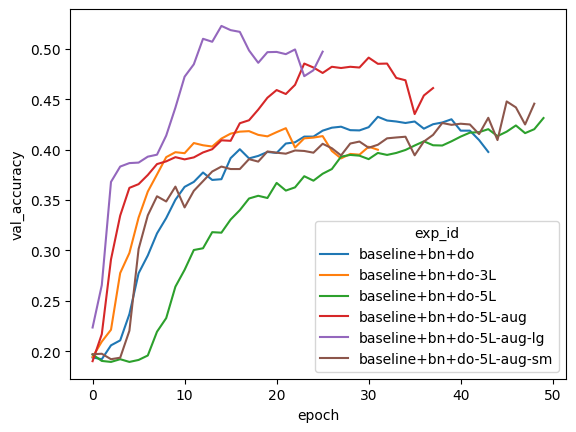

In [115]:
plot_experiments_comp(df_results,
      ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L", "baseline+bn+do-5L-aug", "baseline+bn+do-5L-aug-sm", "baseline+bn+do-5L-aug-lg"],
                      "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

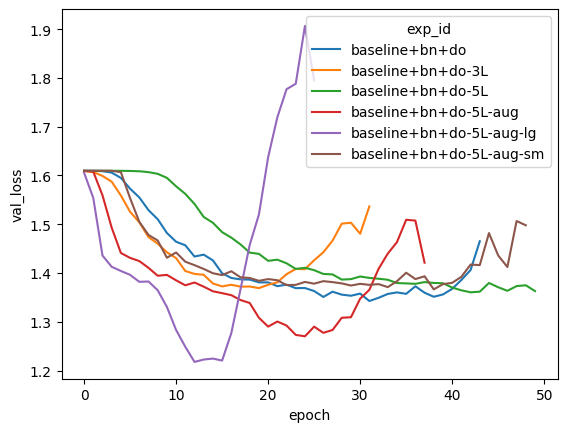

In [116]:
plot_experiments_comp(df_results,
      ["baseline+bn+do", "baseline+bn+do-3L", "baseline+bn+do-5L", "baseline+bn+do-5L-aug", "baseline+bn+do-5L-aug-sm", "baseline+bn+do-5L-aug-lg"],
                      "val_loss")

In [118]:
df_results.to_csv(WORKING_DATA / "results.csv")

In [12]:
df_results = pd.read_csv(WORKING_DATA / "results.csv")

In [12]:
def run_experiment_lr(exp_id: str, sub_exp_id: int, model_fn: str, ds_train_, ds_valid_):
    
    #data = {"exp_id":"1", "desc":"something", "batch_size":BATCH_SIZE, "img_width":0, "img_height":0, "model": model_str}
    #df_experiment = pd.concat([pd.DataFrame([data]), df_experiment])
    
    model = model_fn()
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(epsilon=0.005),
        loss="categorical_crossentropy",
        metrics=['accuracy']
    )

    early_stopping = callbacks.EarlyStopping(
        min_delta=0.0001,
        patience=ES_PATIENCE,
        restore_best_weights=True,
    )
    
    reduce_lr = callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
                                            patience = 3, min_delta = 0.001, 
                                            mode = 'min', verbose = 1)
    
    cbs = []
    if ES:
        print("Using EarlyStopping")
        cbs += [early_stopping]
    if LR:
        print("Using ReduceLROnPlateau")
        cbs += [reduce_lr]

    history = model.fit(
        ds_train_,
        validation_data=ds_valid_,
        epochs=EPOCHS,
        verbose=1,
        callbacks=cbs
    )
    
    df_hist = pd.DataFrame(history.history)
    df_hist = df_hist.reset_index()
    df_hist["exp_id"] = exp_id
    df_hist["sub_exp_id"] = sub_exp_id
    df_hist["epoch"] = df_hist.index
   
    return model, df_hist

In [16]:
df_results.head()

Unnamed: 0  index      loss  accuracy  val_loss  val_accuracy exp_id  \
0           0      0  1.610638  0.195977  1.608816      0.190722      1   
1           1      1  1.608943  0.201374  1.607145      0.198085      1   
2           2      2  1.606056  0.216581  1.601335      0.244477      1   
3           3      3  1.594809  0.246750  1.612779      0.224595      1   
4           4      4  1.577858  0.249448  1.550503      0.321797      1   

   sub_exp_id  epoch  
0           0      0  
1           0      1  
2           0      2  
3           0      3  
4           0      4

In [17]:
ES = True
LR = True
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset(dataset_path, 8)
    (m, df_hist) = run_experiment_lr("baseline+bn+do-5L-aug-lg-plat", i, create_simple_model_bn_do_5l, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Using ReduceLROnPlateau
Epoch 1/50


2024-03-01 16:12:29.938110: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709309556.986161     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


168/168 [==============================] - 80s 368ms/step - loss: 1.6076 - accuracy: 0.2077 - val_loss: 1.6042 - val_accuracy: 0.2283 - lr: 0.0010
Epoch 2/50
168/168 [==============================] - 36s 216ms/step - loss: 1.5383 - accuracy: 0.2781 - val_loss: 1.4815 - val_accuracy: 0.3387 - lr: 0.0010
Epoch 3/50
168/168 [==============================] - 36s 216ms/step - loss: 1.4324 - accuracy: 0.3422 - val_loss: 1.4325 - val_accuracy: 0.3571 - lr: 0.0010
Epoch 4/50
168/168 [==============================] - 36s 216ms/step - loss: 1.3947 - accuracy: 0.3742 - val_loss: 1.4016 - val_accuracy: 0.3675 - lr: 0.0010
Epoch 5/50
168/168 [==============================] - 36s 216ms/step - loss: 1.3672 - accuracy: 0.3916 - val_loss: 1.3985 - val_accuracy: 0.3888 - lr: 0.0010
Epoch 6/50
168/168 [==============================] - 36s 216ms/step - loss: 1.3526 - accuracy: 0.4006 - val_loss: 1.4115 - val_accuracy: 0.3726 - lr: 0.0010
Epoch 7/50
168/168 [==============================] - 36s 216ms

2024-03-01 16:28:55.535758: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_7/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 61s 326ms/step - loss: 1.6093 - accuracy: 0.2039 - val_loss: 1.6086 - val_accuracy: 0.1885 - lr: 0.0010
Epoch 2/50
168/168 [==============================] - 36s 216ms/step - loss: 1.5605 - accuracy: 0.2573 - val_loss: 1.4879 - val_accuracy: 0.3152 - lr: 0.0010
Epoch 3/50
168/168 [==============================] - 36s 216ms/step - loss: 1.4436 - accuracy: 0.3369 - val_loss: 1.4337 - val_accuracy: 0.3571 - lr: 0.0010
Epoch 4/50
168/168 [==============================] - 36s 215ms/step - loss: 1.3928 - accuracy: 0.3772 - val_loss: 1.4051 - val_accuracy: 0.3704 - lr: 0.0010
Epoch 5/50
168/168 [==============================] - 36s 215ms/step - loss: 1.3712 - accuracy: 0.3899 - val_loss: 1.3992 - val_accuracy: 0.3822 - lr: 0.0010
Epoch 6/50
168/168 [==============================] - 36s 215ms/step - loss: 1.3557 - accuracy: 0.3992 - val_loss: 1.4015 - val_accuracy: 0.3814 - lr: 0.0010
Epoch 7/50
168/168 [==============================] - 36s 215ms

2024-03-01 16:44:25.554451: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/dropout_14/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 61s 323ms/step - loss: 1.6084 - accuracy: 0.2055 - val_loss: 1.6066 - val_accuracy: 0.2018 - lr: 0.0010
Epoch 2/50
168/168 [==============================] - 36s 215ms/step - loss: 1.5301 - accuracy: 0.2800 - val_loss: 1.4628 - val_accuracy: 0.3454 - lr: 0.0010
Epoch 3/50
168/168 [==============================] - 36s 215ms/step - loss: 1.4343 - accuracy: 0.3434 - val_loss: 1.4196 - val_accuracy: 0.3807 - lr: 0.0010
Epoch 4/50
168/168 [==============================] - 36s 215ms/step - loss: 1.3864 - accuracy: 0.3779 - val_loss: 1.4002 - val_accuracy: 0.3778 - lr: 0.0010
Epoch 5/50
168/168 [==============================] - 36s 215ms/step - loss: 1.3659 - accuracy: 0.3939 - val_loss: 1.4180 - val_accuracy: 0.3682 - lr: 0.0010
Epoch 6/50
168/168 [==============================] - 36s 215ms/step - loss: 1.3549 - accuracy: 0.4035 - val_loss: 1.4106 - val_accuracy: 0.3748 - lr: 0.0010
Epoch 7/50
168/168 [==============================] - 36s 215ms

In [18]:
df_results.to_csv(WORKING_DATA / "results.csv")

### Using a Pre-trained Model

In [19]:
# quick convnet, similar to that used here: https://www.kaggle.com/code/ryanholbrook/custom-convnets
def use_pre_trained_model() -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        base_model,
        layers.MaxPool2D(),
        layers.Dropout(0.2),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


# m5 = tf.keras.Sequential([
#     base_model,
#     tf.keras.layers.GlobalAveragePooling2D(),
#     tf.keras.layers.Dense(64, activation='relu'),
#     layers.Dropout(0.25),
#     tf.keras.layers.Dense(5, activation='softmax')  
# ])

# lr_scheduler = keras.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=1e-5, 
#     decay_steps=10000, 
#     decay_rate=0.9)

# m5.compile(
#     optimizer=tf.keras.optimizers.Adam(epsilon=0.001),
#     loss="categorical_crossentropy",
#     metrics=['accuracy']
# )

# early_stopping = callbacks.EarlyStopping(
#     min_delta=0.0001,
#     patience=30,
#     restore_best_weights=True,
# )

# early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, 
#                                               patience = 10, mode = 'min', verbose = 1,
#                                               restore_best_weights = True)

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.3, 
#                                                  patience = 2, min_delta = 0.001, 
#                                                  mode = 'min', verbose = 1)

# ds_train_aug, ds_valid_aug = get_equal_split_aug_dataset2(full_dataset_path)

# history = m5.fit(
#     ds_train_aug,
#     validation_data=ds_valid_aug,
#     epochs=10,
#     verbose=1,
#     callbacks=[early_stop, reduce_lr],
# )



# m5.evaluate(ds_valid_aug)

In [20]:
ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset(dataset_path, 8)
    (m, df_hist) = run_experiment_lr("pretrained_baseline", i, use_pre_trained_model, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
16705208/16705208 [==============================] - 0s 0us/step
Using EarlyStopping
Epoch 1/50


2024-03-01 16:59:26.838923: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 69s 341ms/step - loss: 1.6147 - accuracy: 0.2448 - val_loss: 1.6233 - val_accuracy: 0.1944
Epoch 2/50
168/168 [==============================] - 32s 190ms/step - loss: 1.5289 - accuracy: 0.2972 - val_loss: 1.5145 - val_accuracy: 0.3049
Epoch 3/50
168/168 [==============================] - 32s 189ms/step - loss: 1.5016 - accuracy: 0.3140 - val_loss: 1.4582 - val_accuracy: 0.3756
Epoch 4/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4782 - accuracy: 0.3317 - val_loss: 1.4413 - val_accuracy: 0.3895
Epoch 5/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4629 - accuracy: 0.3418 - val_loss: 1.4308 - val_accuracy: 0.3873
Epoch 6/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4472 - accuracy: 0.3549 - val_loss: 1.4176 - val_accuracy: 0.3940
Epoch 7/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4378 - accuracy: 0.3607 - val_loss: 1.4086 - val_accuracy: 0.3

2024-03-01 17:16:35.620821: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 65s 328ms/step - loss: 1.6069 - accuracy: 0.2476 - val_loss: 1.6325 - val_accuracy: 0.1907
Epoch 2/50
168/168 [==============================] - 32s 190ms/step - loss: 1.5258 - accuracy: 0.2999 - val_loss: 1.5170 - val_accuracy: 0.3218
Epoch 3/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4985 - accuracy: 0.3174 - val_loss: 1.4636 - val_accuracy: 0.3704
Epoch 4/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4729 - accuracy: 0.3337 - val_loss: 1.4462 - val_accuracy: 0.3859
Epoch 5/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4623 - accuracy: 0.3431 - val_loss: 1.4374 - val_accuracy: 0.3903
Epoch 6/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4490 - accuracy: 0.3493 - val_loss: 1.4250 - val_accuracy: 0.4153
Epoch 7/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4397 - accuracy: 0.3557 - val_loss: 1.4193 - val_accuracy: 0.4

2024-03-01 17:32:39.155047: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 66s 332ms/step - loss: 1.6106 - accuracy: 0.2423 - val_loss: 1.6275 - val_accuracy: 0.1981
Epoch 2/50
168/168 [==============================] - 32s 190ms/step - loss: 1.5297 - accuracy: 0.2975 - val_loss: 1.5193 - val_accuracy: 0.3166
Epoch 3/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4986 - accuracy: 0.3169 - val_loss: 1.4617 - val_accuracy: 0.3638
Epoch 4/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4804 - accuracy: 0.3272 - val_loss: 1.4447 - val_accuracy: 0.3851
Epoch 5/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4637 - accuracy: 0.3361 - val_loss: 1.4358 - val_accuracy: 0.4021
Epoch 6/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4500 - accuracy: 0.3530 - val_loss: 1.4271 - val_accuracy: 0.4087
Epoch 7/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4361 - accuracy: 0.3629 - val_loss: 1.4141 - val_accuracy: 0.4

In [21]:
df_results.to_csv(WORKING_DATA / "results.csv")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

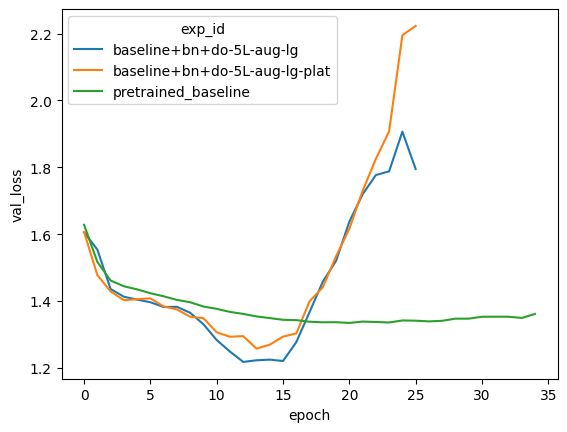

In [23]:
plot_experiments_comp(df_results,["baseline+bn+do-5L-aug-lg-plat", "pretrained_baseline", "baseline+bn+do-5L-aug-lg"], "val_loss")

In [ ]:
def use_pre_trained_model_avg() -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset(dataset_path, 8)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg", i, use_pre_trained_model_avg, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


2024-03-01 18:10:35.566965: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 66s 330ms/step - loss: 1.5792 - accuracy: 0.2594 - val_loss: 1.6531 - val_accuracy: 0.1937
Epoch 2/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4905 - accuracy: 0.3233 - val_loss: 1.4863 - val_accuracy: 0.3343
Epoch 3/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4637 - accuracy: 0.3422 - val_loss: 1.4346 - val_accuracy: 0.3763
Epoch 4/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4445 - accuracy: 0.3548 - val_loss: 1.4173 - val_accuracy: 0.4021
Epoch 5/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4281 - accuracy: 0.3645 - val_loss: 1.4025 - val_accuracy: 0.4102
Epoch 6/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4107 - accuracy: 0.3807 - val_loss: 1.3915 - val_accuracy: 0.4146
Epoch 7/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3934 - accuracy: 0.3898 - val_loss: 1.3819 - val_accuracy: 0.4

2024-03-01 18:25:33.865744: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 65s 329ms/step - loss: 1.5806 - accuracy: 0.2599 - val_loss: 1.6585 - val_accuracy: 0.1922
Epoch 2/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4892 - accuracy: 0.3223 - val_loss: 1.4914 - val_accuracy: 0.3166
Epoch 3/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4573 - accuracy: 0.3449 - val_loss: 1.4341 - val_accuracy: 0.3932
Epoch 4/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4403 - accuracy: 0.3570 - val_loss: 1.4183 - val_accuracy: 0.3984
Epoch 5/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4220 - accuracy: 0.3704 - val_loss: 1.4031 - val_accuracy: 0.4131
Epoch 6/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4023 - accuracy: 0.3841 - val_loss: 1.3907 - val_accuracy: 0.4124
Epoch 7/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3853 - accuracy: 0.3991 - val_loss: 1.3776 - val_accuracy: 0.4

In [ ]:
df_results.to_csv(WORKING_DATA / "results.csv")

In [14]:
df_results = pd.read_csv(WORKING_DATA / "results.csv")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

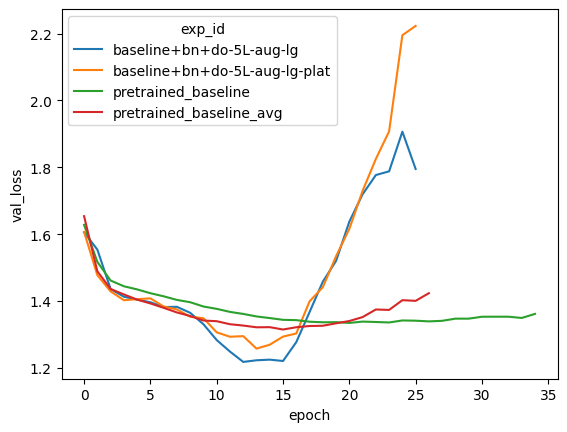

In [22]:
plot_experiments_comp(df_results,["pretrained_baseline", "pretrained_baseline_avg", "baseline+bn+do-5L-aug-lg-plat", "baseline+bn+do-5L-aug-lg"], "val_loss")

In [13]:
def get_equal_split_aug_dataset_raw(path: Path, repeat: int):
    # Load dataset
    # categorical here means that the labels are one-hot encoded
    ds_train_, ds_valid_ = image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[255, 255],
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=VALIDATION_SPLIT,
        subset="both",
        seed=31415,
    )   

    # Data Pipeline
    def convert_to_float(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, 0.2)
#         image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#         image = image / 255.0
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .repeat(repeat)
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    return ds_train, ds_valid

In [30]:
def use_pre_trained_model_avg_bn() -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        layers.BatchNormalization(),
        
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset(dataset_path, 8)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_bn", i, use_pre_trained_model_avg_bn, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


2024-03-01 22:07:27.931091: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 66s 328ms/step - loss: 1.6382 - accuracy: 0.2937 - val_loss: 1.6135 - val_accuracy: 0.1937
Epoch 2/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4723 - accuracy: 0.3431 - val_loss: 1.5271 - val_accuracy: 0.3071
Epoch 3/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4265 - accuracy: 0.3668 - val_loss: 1.4472 - val_accuracy: 0.4028
Epoch 4/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3978 - accuracy: 0.3842 - val_loss: 1.4136 - val_accuracy: 0.4072
Epoch 5/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3797 - accuracy: 0.3924 - val_loss: 1.3979 - val_accuracy: 0.3976
Epoch 6/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3561 - accuracy: 0.4076 - val_loss: 1.3955 - val_accuracy: 0.4227
Epoch 7/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3336 - accuracy: 0.4180 - val_loss: 1.3950 - val_accuracy: 0.4

2024-03-01 22:17:41.110764: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 66s 332ms/step - loss: 1.6265 - accuracy: 0.2942 - val_loss: 1.6065 - val_accuracy: 0.2010
Epoch 2/50
168/168 [==============================] - 32s 191ms/step - loss: 1.4772 - accuracy: 0.3382 - val_loss: 1.5327 - val_accuracy: 0.3233
Epoch 3/50
168/168 [==============================] - 32s 191ms/step - loss: 1.4233 - accuracy: 0.3660 - val_loss: 1.4536 - val_accuracy: 0.3807
Epoch 4/50
168/168 [==============================] - 32s 191ms/step - loss: 1.3952 - accuracy: 0.3859 - val_loss: 1.4124 - val_accuracy: 0.3991
Epoch 5/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3765 - accuracy: 0.3935 - val_loss: 1.4037 - val_accuracy: 0.4021
Epoch 6/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3553 - accuracy: 0.4068 - val_loss: 1.4053 - val_accuracy: 0.3895
Epoch 7/50
168/168 [==============================] - 32s 191ms/step - loss: 1.3326 - accuracy: 0.4207 - val_loss: 1.4024 - val_accuracy: 0.4

2024-03-01 22:27:24.258148: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


168/168 [==============================] - 66s 327ms/step - loss: 1.6417 - accuracy: 0.2950 - val_loss: 1.6119 - val_accuracy: 0.1922
Epoch 2/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4758 - accuracy: 0.3404 - val_loss: 1.5321 - val_accuracy: 0.3240
Epoch 3/50
168/168 [==============================] - 32s 190ms/step - loss: 1.4300 - accuracy: 0.3640 - val_loss: 1.4458 - val_accuracy: 0.4035
Epoch 4/50
168/168 [==============================] - 32s 191ms/step - loss: 1.3959 - accuracy: 0.3850 - val_loss: 1.4082 - val_accuracy: 0.4109
Epoch 5/50
168/168 [==============================] - 32s 191ms/step - loss: 1.3767 - accuracy: 0.3957 - val_loss: 1.3980 - val_accuracy: 0.3947
Epoch 6/50
168/168 [==============================] - 32s 190ms/step - loss: 1.3577 - accuracy: 0.4063 - val_loss: 1.3943 - val_accuracy: 0.3962
Epoch 7/50
168/168 [==============================] - 32s 191ms/step - loss: 1.3342 - accuracy: 0.4161 - val_loss: 1.3903 - val_accuracy: 0.4

In [32]:
df_results.to_csv(WORKING_DATA / "results.csv")

In [24]:
def use_pre_trained_model_avg_no_bn() -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(dataset_path, 7)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn", i, use_pre_trained_model_avg_no_bn, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
16705208/16705208 [==============================] - 1s 0us/step
Using EarlyStopping
Epoch 1/50


2024-03-02 21:35:08.220690: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709415313.155251     112 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


147/147 [==============================] - 57s 312ms/step - loss: 1.4158 - accuracy: 0.3814 - val_loss: 1.2090 - val_accuracy: 0.5044
Epoch 2/50
147/147 [==============================] - 10s 70ms/step - loss: 1.2063 - accuracy: 0.5039 - val_loss: 1.1476 - val_accuracy: 0.5309
Epoch 3/50
147/147 [==============================] - 10s 70ms/step - loss: 1.1193 - accuracy: 0.5448 - val_loss: 1.1228 - val_accuracy: 0.5390
Epoch 4/50
147/147 [==============================] - 10s 70ms/step - loss: 1.0597 - accuracy: 0.5715 - val_loss: 1.1137 - val_accuracy: 0.5501
Epoch 5/50
147/147 [==============================] - 10s 70ms/step - loss: 1.0016 - accuracy: 0.6033 - val_loss: 1.1156 - val_accuracy: 0.5560
Epoch 6/50
147/147 [==============================] - 10s 69ms/step - loss: 0.9430 - accuracy: 0.6285 - val_loss: 1.1236 - val_accuracy: 0.5515
Epoch 7/50
147/147 [==============================] - 10s 69ms/step - loss: 0.8849 - accuracy: 0.6529 - val_loss: 1.1369 - val_accuracy: 0.5493
Ep

2024-03-02 21:38:21.803166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 [==============================] - 52s 292ms/step - loss: 1.4101 - accuracy: 0.3846 - val_loss: 1.2116 - val_accuracy: 0.4956
Epoch 2/50
147/147 [==============================] - 10s 70ms/step - loss: 1.2074 - accuracy: 0.5022 - val_loss: 1.1570 - val_accuracy: 0.5199
Epoch 3/50
147/147 [==============================] - 10s 70ms/step - loss: 1.1253 - accuracy: 0.5429 - val_loss: 1.1385 - val_accuracy: 0.5412
Epoch 4/50
147/147 [==============================] - 10s 70ms/step - loss: 1.0645 - accuracy: 0.5695 - val_loss: 1.1229 - val_accuracy: 0.5412
Epoch 5/50
147/147 [==============================] - 10s 70ms/step - loss: 1.0096 - accuracy: 0.5985 - val_loss: 1.1259 - val_accuracy: 0.5457
Epoch 6/50
147/147 [==============================] - 10s 70ms/step - loss: 0.9488 - accuracy: 0.6241 - val_loss: 1.1259 - val_accuracy: 0.5457
Epoch 7/50
147/147 [==============================] - 10s 70ms/step - loss: 0.8906 - accuracy: 0.6495 - val_loss: 1.1575 - val_accuracy: 0.5434
Ep

2024-03-02 21:41:31.453897: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 [==============================] - 52s 292ms/step - loss: 1.4102 - accuracy: 0.3867 - val_loss: 1.2072 - val_accuracy: 0.5081
Epoch 2/50
147/147 [==============================] - 10s 70ms/step - loss: 1.2048 - accuracy: 0.5049 - val_loss: 1.1454 - val_accuracy: 0.5280
Epoch 3/50
147/147 [==============================] - 10s 71ms/step - loss: 1.1216 - accuracy: 0.5444 - val_loss: 1.1236 - val_accuracy: 0.5412
Epoch 4/50
147/147 [==============================] - 10s 70ms/step - loss: 1.0594 - accuracy: 0.5773 - val_loss: 1.1193 - val_accuracy: 0.5412
Epoch 5/50
147/147 [==============================] - 10s 69ms/step - loss: 1.0063 - accuracy: 0.5965 - val_loss: 1.1202 - val_accuracy: 0.5501
Epoch 6/50
147/147 [==============================] - 10s 69ms/step - loss: 0.9473 - accuracy: 0.6261 - val_loss: 1.1203 - val_accuracy: 0.5670
Epoch 7/50
147/147 [==============================] - 10s 70ms/step - loss: 0.8841 - accuracy: 0.6532 - val_loss: 1.1309 - val_accuracy: 0.5685
Ep

In [ ]:
df_results.to_csv(WORKING_DATA / "results.csv")

In [27]:
def use_pre_trained_model_max_no_bn() -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        base_model,
        layers.MaxPool2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(dataset_path, 7)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_max_no_bn", i, use_pre_trained_model_max_no_bn, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


2024-03-02 21:52:46.248596: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 [==============================] - 52s 294ms/step - loss: 1.4818 - accuracy: 0.3780 - val_loss: 1.2371 - val_accuracy: 0.4853
Epoch 2/50
147/147 [==============================] - 10s 70ms/step - loss: 1.2439 - accuracy: 0.4862 - val_loss: 1.1901 - val_accuracy: 0.5162
Epoch 3/50
147/147 [==============================] - 10s 70ms/step - loss: 1.1463 - accuracy: 0.5303 - val_loss: 1.1651 - val_accuracy: 0.5317
Epoch 4/50
147/147 [==============================] - 10s 70ms/step - loss: 1.0771 - accuracy: 0.5674 - val_loss: 1.1555 - val_accuracy: 0.5376
Epoch 5/50
147/147 [==============================] - 10s 69ms/step - loss: 1.0080 - accuracy: 0.5964 - val_loss: 1.1588 - val_accuracy: 0.5515
Epoch 6/50
147/147 [==============================] - 10s 69ms/step - loss: 0.9454 - accuracy: 0.6257 - val_loss: 1.1657 - val_accuracy: 0.5538
Epoch 7/50
147/147 [==============================] - 10s 69ms/step - loss: 0.8856 - accuracy: 0.6538 - val_loss: 1.1993 - val_accuracy: 0.5449
Ep

2024-03-02 21:55:55.969134: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 [==============================] - 52s 295ms/step - loss: 1.4777 - accuracy: 0.3803 - val_loss: 1.2355 - val_accuracy: 0.4882
Epoch 2/50
147/147 [==============================] - 10s 70ms/step - loss: 1.2413 - accuracy: 0.4872 - val_loss: 1.1874 - val_accuracy: 0.5052
Epoch 3/50
147/147 [==============================] - 10s 70ms/step - loss: 1.1513 - accuracy: 0.5307 - val_loss: 1.1689 - val_accuracy: 0.5118
Epoch 4/50
147/147 [==============================] - 10s 70ms/step - loss: 1.0796 - accuracy: 0.5622 - val_loss: 1.1627 - val_accuracy: 0.5177
Epoch 5/50
147/147 [==============================] - 10s 69ms/step - loss: 1.0165 - accuracy: 0.5944 - val_loss: 1.1695 - val_accuracy: 0.5184
Epoch 6/50
147/147 [==============================] - 10s 69ms/step - loss: 0.9541 - accuracy: 0.6234 - val_loss: 1.1789 - val_accuracy: 0.5250
Epoch 7/50
147/147 [==============================] - 10s 69ms/step - loss: 0.8946 - accuracy: 0.6468 - val_loss: 1.1948 - val_accuracy: 0.5309
Ep

2024-03-02 21:59:04.837778: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


147/147 [==============================] - 53s 298ms/step - loss: 1.4845 - accuracy: 0.3778 - val_loss: 1.2461 - val_accuracy: 0.4853
Epoch 2/50
147/147 [==============================] - 10s 70ms/step - loss: 1.2416 - accuracy: 0.4822 - val_loss: 1.1997 - val_accuracy: 0.5007
Epoch 3/50
147/147 [==============================] - 10s 69ms/step - loss: 1.1546 - accuracy: 0.5297 - val_loss: 1.1810 - val_accuracy: 0.5140
Epoch 4/50
147/147 [==============================] - 10s 70ms/step - loss: 1.0801 - accuracy: 0.5605 - val_loss: 1.1763 - val_accuracy: 0.5162
Epoch 5/50
147/147 [==============================] - 10s 69ms/step - loss: 1.0179 - accuracy: 0.5932 - val_loss: 1.1789 - val_accuracy: 0.5258
Epoch 6/50
147/147 [==============================] - 10s 69ms/step - loss: 0.9584 - accuracy: 0.6180 - val_loss: 1.1838 - val_accuracy: 0.5339
Epoch 7/50
147/147 [==============================] - 10s 69ms/step - loss: 0.8941 - accuracy: 0.6489 - val_loss: 1.2108 - val_accuracy: 0.5383
Ep

In [21]:
def use_pre_trained_model_avg_no_bn_train() -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = True
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])


In [ ]:
ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 3):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(dataset_path, 7)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn_train", i, use_pre_trained_model_avg_no_bn_train, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

In [19]:
df_results = pd.read_csv(WORKING_DATA / "results.csv")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

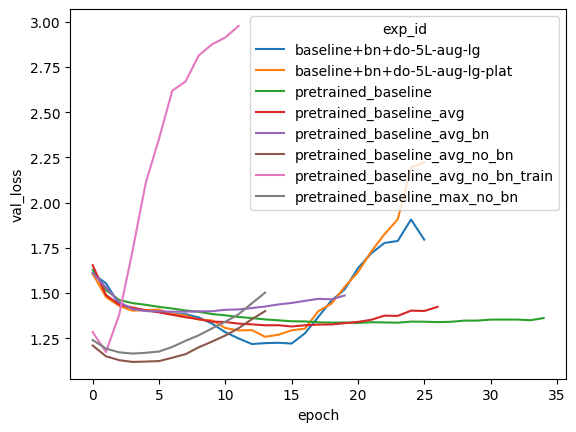

In [32]:
plot_experiments_comp(df_results,["pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "pretrained_baseline_avg", "baseline+bn+do-5L-aug-lg-plat", "baseline+bn+do-5L-aug-lg"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

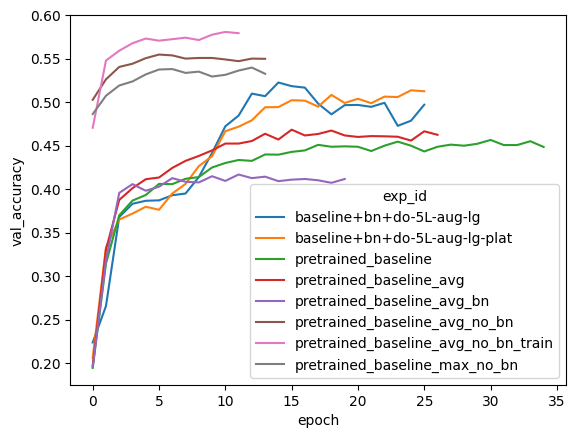

In [33]:
plot_experiments_comp(df_results,["pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "pretrained_baseline_avg", "baseline+bn+do-5L-aug-lg-plat", "baseline+bn+do-5L-aug-lg"], "val_accuracy")

### Load All Data

In [23]:
def create_full_dataset(df_map: pd.DataFrame) -> Path:
    es_path = WORKING_DATA / "full"
    if not es_path.exists():
        es_path.mkdir(parents=True, exist_ok=True)

        for lab in df_map.label.unique():
            (es_path / str(lab)).mkdir(exist_ok=True)

        source_path = SOURCE_DATA / "train_images"

        for index, row in df_map.iterrows():
            lab = row["label"]
            image_id = row["image_id"]
            img = source_path / image_id
            dest = es_path / str(lab) / image_id
            shutil.copyfile(img, dest)
        
    return es_path

In [24]:
full_dataset_path = create_full_dataset(df_train)

In [31]:
IMAGE_SIZE = 120
ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 2)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn_train_full", i, use_pre_trained_model_avg_no_bn_train, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
Using EarlyStopping
Epoch 1/50


2024-03-03 10:33:33.781803: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


164/164 [==============================] - 101s 404ms/step - loss: 1.0797 - accuracy: 0.6187 - val_loss: 0.9059 - val_accuracy: 0.6631
Epoch 2/50
164/164 [==============================] - 54s 328ms/step - loss: 0.8052 - accuracy: 0.6963 - val_loss: 0.7664 - val_accuracy: 0.7241
Epoch 3/50
164/164 [==============================] - 54s 329ms/step - loss: 0.6486 - accuracy: 0.7497 - val_loss: 0.7344 - val_accuracy: 0.7381
Epoch 4/50
164/164 [==============================] - 54s 332ms/step - loss: 0.5122 - accuracy: 0.8039 - val_loss: 0.7732 - val_accuracy: 0.7373
Epoch 5/50
164/164 [==============================] - 55s 333ms/step - loss: 0.4002 - accuracy: 0.8506 - val_loss: 0.8626 - val_accuracy: 0.7452
Epoch 6/50
164/164 [==============================] - 55s 333ms/step - loss: 0.3047 - accuracy: 0.8903 - val_loss: 0.9531 - val_accuracy: 0.7435
Epoch 7/50
164/164 [==============================] - 55s 334ms/step - loss: 0.2309 - accuracy: 0.9185 - val_loss: 1.0879 - val_accuracy: 0.

2024-03-03 10:46:12.413448: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


164/164 [==============================] - 99s 400ms/step - loss: 1.0872 - accuracy: 0.6138 - val_loss: 0.9082 - val_accuracy: 0.6611
Epoch 2/50
164/164 [==============================] - 54s 330ms/step - loss: 0.8048 - accuracy: 0.6975 - val_loss: 0.7867 - val_accuracy: 0.7269
Epoch 3/50
164/164 [==============================] - 54s 331ms/step - loss: 0.6439 - accuracy: 0.7545 - val_loss: 0.7569 - val_accuracy: 0.7435
Epoch 4/50
164/164 [==============================] - 55s 333ms/step - loss: 0.5122 - accuracy: 0.8047 - val_loss: 0.7810 - val_accuracy: 0.7515
Epoch 5/50
164/164 [==============================] - 54s 328ms/step - loss: 0.3968 - accuracy: 0.8522 - val_loss: 0.8799 - val_accuracy: 0.7388
Epoch 6/50
164/164 [==============================] - 54s 331ms/step - loss: 0.3090 - accuracy: 0.8877 - val_loss: 0.9630 - val_accuracy: 0.7355
Epoch 7/50
164/164 [==============================] - 54s 331ms/step - loss: 0.2252 - accuracy: 0.9209 - val_loss: 1.0980 - val_accuracy: 0.7

In [35]:
IMAGE_SIZE = 160

In [14]:
def get_equal_split_aug_dataset_raw(path: Path, repeat: int):
    # Load dataset
    # categorical here means that the labels are one-hot encoded
    ds_train_, ds_valid_ = image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='categorical',
        image_size=[IMAGE_SIZE, IMAGE_SIZE],
        batch_size=BATCH_SIZE,
        shuffle=True,
        validation_split=VALIDATION_SPLIT,
        subset="both",
        seed=31415,
    )   

    # Data Pipeline
    def convert_to_float(image, label):
        image = tf.image.random_flip_left_right(image)
        image = tf.image.random_flip_up_down(image)
        image = tf.image.random_brightness(image, 0.2)
#         image = tf.image.convert_image_dtype(image, dtype=tf.float32)
#         image = image / 255.0
        return image, label

    AUTOTUNE = tf.data.experimental.AUTOTUNE
    ds_train = (
        ds_train_
        .repeat(repeat)
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    ds_valid = (
        ds_valid_
        .map(convert_to_float)
        .cache()
        .prefetch(buffer_size=AUTOTUNE)
    )
    
    return ds_train, ds_valid

In [28]:
ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 1)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn_train_full_big", i, use_pre_trained_model_avg_no_bn_train, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
Using EarlyStopping
Epoch 1/50


2024-03-03 09:53:51.228111: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 98s 780ms/step - loss: 1.1565 - accuracy: 0.5923 - val_loss: 1.0176 - val_accuracy: 0.6194
Epoch 2/50
82/82 [==============================] - 53s 649ms/step - loss: 0.8913 - accuracy: 0.6629 - val_loss: 0.8687 - val_accuracy: 0.6880
Epoch 3/50
82/82 [==============================] - 53s 651ms/step - loss: 0.7574 - accuracy: 0.7093 - val_loss: 0.7750 - val_accuracy: 0.7295
Epoch 4/50
82/82 [==============================] - 54s 655ms/step - loss: 0.6321 - accuracy: 0.7542 - val_loss: 0.7311 - val_accuracy: 0.7523
Epoch 5/50
82/82 [==============================] - 53s 651ms/step - loss: 0.5322 - accuracy: 0.7962 - val_loss: 0.7327 - val_accuracy: 0.7646
Epoch 6/50
82/82 [==============================] - 53s 646ms/step - loss: 0.4475 - accuracy: 0.8278 - val_loss: 0.7812 - val_accuracy: 0.7710
Epoch 7/50
82/82 [==============================] - 53s 648ms/step - loss: 0.3750 - accuracy: 0.8597 - val_loss: 0.8510 - val_accuracy: 0.7710
Epoch 8/50

2024-03-03 10:07:35.634084: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 96s 764ms/step - loss: 1.1544 - accuracy: 0.5941 - val_loss: 1.0398 - val_accuracy: 0.6143
Epoch 2/50
82/82 [==============================] - 54s 654ms/step - loss: 0.9031 - accuracy: 0.6611 - val_loss: 0.8892 - val_accuracy: 0.6798
Epoch 3/50
82/82 [==============================] - 54s 657ms/step - loss: 0.7591 - accuracy: 0.7099 - val_loss: 0.7924 - val_accuracy: 0.7196
Epoch 4/50
82/82 [==============================] - 54s 653ms/step - loss: 0.6327 - accuracy: 0.7593 - val_loss: 0.7311 - val_accuracy: 0.7491
Epoch 5/50
82/82 [==============================] - 53s 652ms/step - loss: 0.5341 - accuracy: 0.7976 - val_loss: 0.7613 - val_accuracy: 0.7540
Epoch 6/50
82/82 [==============================] - 53s 653ms/step - loss: 0.4432 - accuracy: 0.8319 - val_loss: 0.7528 - val_accuracy: 0.7573
Epoch 7/50
82/82 [==============================] - 54s 654ms/step - loss: 0.3683 - accuracy: 0.8626 - val_loss: 0.8644 - val_accuracy: 0.7624
Epoch 8/50

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

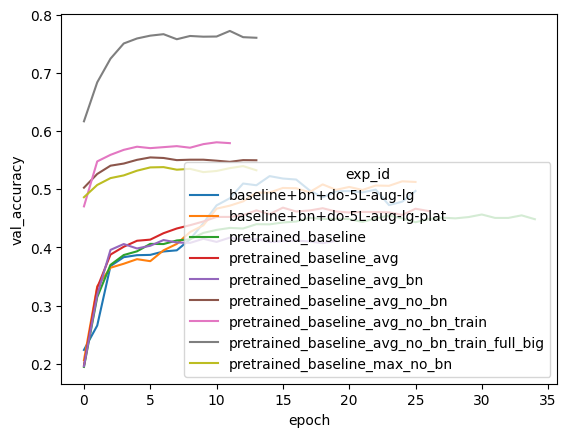

In [29]:
plot_experiments_comp(df_results,["pretrained_baseline_avg_no_bn_train_full_big", "pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "pretrained_baseline_avg", "baseline+bn+do-5L-aug-lg-plat", "baseline+bn+do-5L-aug-lg"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

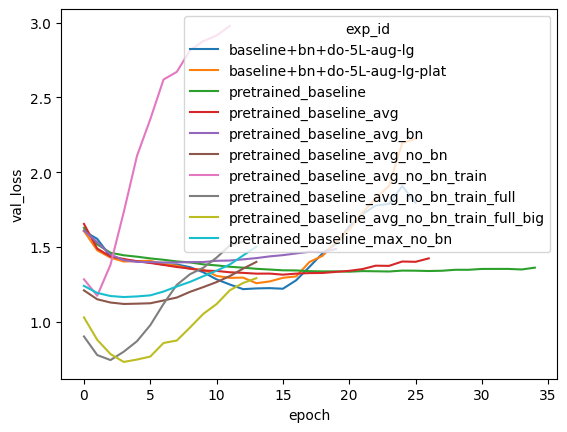

In [33]:
plot_experiments_comp(df_results,["pretrained_baseline_avg_no_bn_train_full_big", "pretrained_baseline_avg_no_bn_train_full", "pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "pretrained_baseline_avg", "baseline+bn+do-5L-aug-lg-plat", "baseline+bn+do-5L-aug-lg"], "val_loss")

In [21]:
def use_pre_trained_model_avg_no_bn_no_train() -> Model:
    
    base_model = tf.keras.applications.EfficientNetB0(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [36]:
ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 1)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn_no_train_full_big", i, use_pre_trained_model_avg_no_bn_no_train, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
Using EarlyStopping
Epoch 1/50


2024-03-03 11:01:32.054020: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 47s 459ms/step - loss: 1.0896 - accuracy: 0.6124 - val_loss: 0.8807 - val_accuracy: 0.6816
Epoch 2/50
82/82 [==============================] - 13s 162ms/step - loss: 0.8955 - accuracy: 0.6681 - val_loss: 0.8011 - val_accuracy: 0.7072
Epoch 3/50
82/82 [==============================] - 13s 162ms/step - loss: 0.8337 - accuracy: 0.6922 - val_loss: 0.7693 - val_accuracy: 0.7181
Epoch 4/50
82/82 [==============================] - 13s 162ms/step - loss: 0.7967 - accuracy: 0.7083 - val_loss: 0.7509 - val_accuracy: 0.7231
Epoch 5/50
82/82 [==============================] - 13s 162ms/step - loss: 0.7681 - accuracy: 0.7172 - val_loss: 0.7377 - val_accuracy: 0.7257
Epoch 6/50
82/82 [==============================] - 13s 162ms/step - loss: 0.7581 - accuracy: 0.7208 - val_loss: 0.7287 - val_accuracy: 0.7317
Epoch 7/50
82/82 [==============================] - 13s 162ms/step - loss: 0.7349 - accuracy: 0.7303 - val_loss: 0.7229 - val_accuracy: 0.7325
Epoch 8/50

2024-03-03 11:07:54.210116: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_9/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 47s 455ms/step - loss: 1.0856 - accuracy: 0.6167 - val_loss: 0.8797 - val_accuracy: 0.6803
Epoch 2/50
82/82 [==============================] - 13s 162ms/step - loss: 0.8910 - accuracy: 0.6695 - val_loss: 0.8051 - val_accuracy: 0.7035
Epoch 3/50
82/82 [==============================] - 13s 162ms/step - loss: 0.8366 - accuracy: 0.6907 - val_loss: 0.7781 - val_accuracy: 0.7100
Epoch 4/50
82/82 [==============================] - 13s 162ms/step - loss: 0.8008 - accuracy: 0.7048 - val_loss: 0.7609 - val_accuracy: 0.7145
Epoch 5/50
82/82 [==============================] - 13s 162ms/step - loss: 0.7755 - accuracy: 0.7154 - val_loss: 0.7535 - val_accuracy: 0.7171
Epoch 6/50
82/82 [==============================] - 13s 162ms/step - loss: 0.7552 - accuracy: 0.7232 - val_loss: 0.7396 - val_accuracy: 0.7203
Epoch 7/50
82/82 [==============================] - 13s 162ms/step - loss: 0.7418 - accuracy: 0.7272 - val_loss: 0.7341 - val_accuracy: 0.7224
Epoch 8/50

In [24]:
ES = True
LR = True
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 1)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn_no_train_full_big_lr", i, use_pre_trained_model_avg_no_bn_no_train, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
Using EarlyStopping
Using ReduceLROnPlateau
Epoch 1/50


2024-03-03 13:26:24.677336: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 40s 369ms/step - loss: 1.1232 - accuracy: 0.6071 - val_loss: 0.9475 - val_accuracy: 0.6571 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 7s 89ms/step - loss: 0.9530 - accuracy: 0.6560 - val_loss: 0.8690 - val_accuracy: 0.6829 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 7s 90ms/step - loss: 0.8940 - accuracy: 0.6727 - val_loss: 0.8389 - val_accuracy: 0.6923 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 7s 90ms/step - loss: 0.8666 - accuracy: 0.6830 - val_loss: 0.8202 - val_accuracy: 0.6988 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 7s 89ms/step - loss: 0.8444 - accuracy: 0.6932 - val_loss: 0.8079 - val_accuracy: 0.7013 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - 7s 90ms/step - loss: 0.8240 - accuracy: 0.6995 - val_loss: 0.7991 - val_accuracy: 0.7054 - lr: 0.0010
Epoch 7/50
82/82 [==============================] - 7s 90ms/step - loss: 0.8054 - acc

2024-03-03 13:30:11.928525: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 39s 366ms/step - loss: 1.1207 - accuracy: 0.6090 - val_loss: 0.9399 - val_accuracy: 0.6633 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 7s 90ms/step - loss: 0.9481 - accuracy: 0.6597 - val_loss: 0.8676 - val_accuracy: 0.6822 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 7s 91ms/step - loss: 0.8941 - accuracy: 0.6747 - val_loss: 0.8405 - val_accuracy: 0.6949 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 7s 90ms/step - loss: 0.8671 - accuracy: 0.6826 - val_loss: 0.8249 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 7s 90ms/step - loss: 0.8384 - accuracy: 0.6931 - val_loss: 0.8120 - val_accuracy: 0.7031 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - 7s 90ms/step - loss: 0.8268 - accuracy: 0.6978 - val_loss: 0.8071 - val_accuracy: 0.7042 - lr: 0.0010
Epoch 7/50
82/82 [==============================] - 7s 90ms/step - loss: 0.8133 - acc

In [31]:
ES = True
LR = True
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 1)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn_train_full_big_lr", i, use_pre_trained_model_avg_no_bn_train, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
Using EarlyStopping
Using ReduceLROnPlateau
Epoch 1/50


2024-03-03 14:06:31.034432: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 76s 452ms/step - loss: 1.1889 - accuracy: 0.5867 - val_loss: 1.0376 - val_accuracy: 0.6169 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 28s 348ms/step - loss: 0.9518 - accuracy: 0.6480 - val_loss: 0.9349 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 28s 347ms/step - loss: 0.8224 - accuracy: 0.6861 - val_loss: 0.8514 - val_accuracy: 0.6973 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 28s 346ms/step - loss: 0.7078 - accuracy: 0.7262 - val_loss: 0.8506 - val_accuracy: 0.7164 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 28s 347ms/step - loss: 0.6078 - accuracy: 0.7607 - val_loss: 0.8597 - val_accuracy: 0.7261 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - ETA: 0s - loss: 0.5186 - accuracy: 0.7953
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 28s 346ms/step - los

2024-03-03 14:14:00.917136: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 71s 447ms/step - loss: 1.1980 - accuracy: 0.5829 - val_loss: 1.0472 - val_accuracy: 0.6164 - lr: 0.0010
Epoch 2/50
82/82 [==============================] - 28s 348ms/step - loss: 0.9500 - accuracy: 0.6447 - val_loss: 0.9458 - val_accuracy: 0.6601 - lr: 0.0010
Epoch 3/50
82/82 [==============================] - 28s 347ms/step - loss: 0.8172 - accuracy: 0.6875 - val_loss: 0.8429 - val_accuracy: 0.6971 - lr: 0.0010
Epoch 4/50
82/82 [==============================] - 28s 346ms/step - loss: 0.7079 - accuracy: 0.7248 - val_loss: 0.8625 - val_accuracy: 0.7158 - lr: 0.0010
Epoch 5/50
82/82 [==============================] - 28s 344ms/step - loss: 0.6082 - accuracy: 0.7629 - val_loss: 0.8484 - val_accuracy: 0.7257 - lr: 0.0010
Epoch 6/50
82/82 [==============================] - ETA: 0s - loss: 0.5203 - accuracy: 0.7989
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 28s 343ms/step - los

In [32]:
ES = True
LR = False
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 1)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn_train_full_big2", i, use_pre_trained_model_avg_no_bn_train, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
Using EarlyStopping
Epoch 1/50


2024-03-03 14:28:59.057172: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 71s 448ms/step - loss: 1.1897 - accuracy: 0.5879 - val_loss: 1.0302 - val_accuracy: 0.6192
Epoch 2/50
82/82 [==============================] - 28s 342ms/step - loss: 0.9579 - accuracy: 0.6432 - val_loss: 0.9268 - val_accuracy: 0.6654
Epoch 3/50
82/82 [==============================] - 28s 344ms/step - loss: 0.8139 - accuracy: 0.6908 - val_loss: 0.8909 - val_accuracy: 0.6912
Epoch 4/50
82/82 [==============================] - 28s 346ms/step - loss: 0.7038 - accuracy: 0.7303 - val_loss: 0.8814 - val_accuracy: 0.7156
Epoch 5/50
82/82 [==============================] - 28s 340ms/step - loss: 0.6025 - accuracy: 0.7729 - val_loss: 0.9196 - val_accuracy: 0.7250
Epoch 6/50
82/82 [==============================] - 28s 336ms/step - loss: 0.4993 - accuracy: 0.8071 - val_loss: 0.9383 - val_accuracy: 0.7315
Epoch 7/50
82/82 [==============================] - 28s 336ms/step - loss: 0.4214 - accuracy: 0.8409 - val_loss: 0.9995 - val_accuracy: 0.7259
Epoch 8/50

2024-03-03 14:36:17.532568: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 70s 443ms/step - loss: 1.1777 - accuracy: 0.5964 - val_loss: 1.0451 - val_accuracy: 0.6190
Epoch 2/50
82/82 [==============================] - 28s 342ms/step - loss: 0.9565 - accuracy: 0.6484 - val_loss: 0.9444 - val_accuracy: 0.6700
Epoch 3/50
82/82 [==============================] - 28s 342ms/step - loss: 0.8214 - accuracy: 0.6846 - val_loss: 0.8718 - val_accuracy: 0.6941
Epoch 4/50
82/82 [==============================] - 28s 340ms/step - loss: 0.7136 - accuracy: 0.7255 - val_loss: 0.8421 - val_accuracy: 0.7149
Epoch 5/50
82/82 [==============================] - 28s 341ms/step - loss: 0.6057 - accuracy: 0.7666 - val_loss: 0.8567 - val_accuracy: 0.7226
Epoch 6/50
82/82 [==============================] - 28s 341ms/step - loss: 0.5176 - accuracy: 0.7972 - val_loss: 0.9054 - val_accuracy: 0.7271
Epoch 7/50
82/82 [==============================] - 28s 342ms/step - loss: 0.4306 - accuracy: 0.8350 - val_loss: 0.9279 - val_accuracy: 0.7108
Epoch 8/50

In [25]:
ES = True
LR = False
IMAGE_SIZE = 185
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 1)
    (m, df_hist) = run_experiment_lr("pretrained_baseline_avg_no_bn_train_full_big3", i, use_pre_trained_model_avg_no_bn_train, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
Using EarlyStopping
Epoch 1/50


2024-03-03 21:46:59.426804: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_4/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 113s 964ms/step - loss: 1.1299 - accuracy: 0.5966 - val_loss: 1.0237 - val_accuracy: 0.6194
Epoch 2/50
82/82 [==============================] - 68s 834ms/step - loss: 0.8715 - accuracy: 0.6753 - val_loss: 0.8360 - val_accuracy: 0.6876
Epoch 3/50
82/82 [==============================] - 69s 845ms/step - loss: 0.7243 - accuracy: 0.7279 - val_loss: 0.7199 - val_accuracy: 0.7360
Epoch 4/50
82/82 [==============================] - 70s 849ms/step - loss: 0.5979 - accuracy: 0.7766 - val_loss: 0.6699 - val_accuracy: 0.7691
Epoch 5/50
82/82 [==============================] - 69s 840ms/step - loss: 0.4996 - accuracy: 0.8160 - val_loss: 0.6822 - val_accuracy: 0.7841
Epoch 6/50
82/82 [==============================] - 69s 840ms/step - loss: 0.4132 - accuracy: 0.8446 - val_loss: 0.7120 - val_accuracy: 0.7865
Epoch 7/50
82/82 [==============================] - 69s 839ms/step - loss: 0.3516 - accuracy: 0.8689 - val_loss: 0.7678 - val_accuracy: 0.7902
Epoch 8/5

2024-03-03 22:03:53.253251: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_5/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


82/82 [==============================] - 111s 958ms/step - loss: 1.1246 - accuracy: 0.5991 - val_loss: 1.0042 - val_accuracy: 0.6207
Epoch 2/50
82/82 [==============================] - 69s 840ms/step - loss: 0.8653 - accuracy: 0.6769 - val_loss: 0.8549 - val_accuracy: 0.6927
Epoch 3/50
82/82 [==============================] - 69s 842ms/step - loss: 0.7202 - accuracy: 0.7262 - val_loss: 0.7584 - val_accuracy: 0.7375
Epoch 4/50
82/82 [==============================] - 69s 841ms/step - loss: 0.5963 - accuracy: 0.7754 - val_loss: 0.6961 - val_accuracy: 0.7686
Epoch 5/50
82/82 [==============================] - 69s 840ms/step - loss: 0.4985 - accuracy: 0.8131 - val_loss: 0.6896 - val_accuracy: 0.7687
Epoch 6/50
82/82 [==============================] - 69s 841ms/step - loss: 0.4105 - accuracy: 0.8480 - val_loss: 0.7425 - val_accuracy: 0.7800
Epoch 7/50
82/82 [==============================] - 69s 837ms/step - loss: 0.3433 - accuracy: 0.8756 - val_loss: 0.7738 - val_accuracy: 0.7835
Epoch 8/5

In [18]:
def use_pre_trained_model_convnext() -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [19]:
def use_pre_trained_model_convnext_sm() -> Model:
    
    base_model = tf.keras.applications.ConvNeXtSmall(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [30]:
ES = True
LR = False
IMAGE_SIZE = 185
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 1)
    (m, df_hist) = run_experiment_lr("use_pre_trained_model_convnext", i, use_pre_trained_model_convnext, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
111650432/111650432 [==============================] - 4s 0us/step
Using EarlyStopping
Epoch 1/50
82/82 [==============================] - 84s 807ms/step - loss: 1.0994 - accuracy: 0.6140 - val_loss: 0.8774 - val_accuracy: 0.6710
Epoch 2/50
82/82 [==============================] - 54s 658ms/step - loss: 0.9034 - accuracy: 0.6629 - val_loss: 0.8262 - val_accuracy: 0.6919
Epoch 3/50
82/82 [==============================] - 54s 657ms/step - loss: 0.8470 - accuracy: 0.6871 - val_loss: 0.8030 - val_accuracy: 0.7020
Epoch 4/50
82/82 [==============================] - 54s 658ms/step - loss: 0.8167 - accuracy: 0.6957 - val_loss: 0.7852 - val_accuracy: 0.7095
Epoch 5/50
82/82 [==============================] - 54s 659ms/step - loss: 0.7938 - accuracy: 0.7032 - val_loss: 0.7734 - val_accuracy: 0.7140
Epoch 6/50
82/82 [==============================] - 54s 661ms/step - loss: 0.7707 - accurac

In [25]:
ES = True
LR = False
IMAGE_SIZE = 185
BATCH_SIZE = 196
for i in range(0, 2):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(full_dataset_path, 1)
    (m, df_hist) = run_experiment_lr("use_pre_trained_model_convnext_sm", i, use_pre_trained_model_convnext_sm, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 21397 files belonging to 5 classes.
Using 16048 files for training.
Using 5349 files for validation.
198551472/198551472 [==============================] - 1s 0us/step
Using EarlyStopping
Epoch 1/50


I0000 00:00:1709536957.702004     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


82/82 [==============================] - 135s 1s/step - loss: 1.1006 - accuracy: 0.6137 - val_loss: 0.8801 - val_accuracy: 0.6713
Epoch 2/50
82/82 [==============================] - 87s 1s/step - loss: 0.9213 - accuracy: 0.6610 - val_loss: 0.8354 - val_accuracy: 0.6857
Epoch 3/50
82/82 [==============================] - 87s 1s/step - loss: 0.8717 - accuracy: 0.6774 - val_loss: 0.8098 - val_accuracy: 0.6945
Epoch 4/50
82/82 [==============================] - 87s 1s/step - loss: 0.8373 - accuracy: 0.6880 - val_loss: 0.7930 - val_accuracy: 0.7026
Epoch 5/50
82/82 [==============================] - 87s 1s/step - loss: 0.8149 - accuracy: 0.6952 - val_loss: 0.7782 - val_accuracy: 0.7085
Epoch 6/50
82/82 [==============================] - 87s 1s/step - loss: 0.7941 - accuracy: 0.7086 - val_loss: 0.7690 - val_accuracy: 0.7127
Epoch 7/50
82/82 [==============================] - 87s 1s/step - loss: 0.7756 - accuracy: 0.7122 - val_loss: 0.7559 - val_accuracy: 0.7142
Epoch 8/50
82/82 [============

In [15]:
def use_pre_trained_model_convnext_base() -> Model:
    
    base_model = tf.keras.applications.ConvNeXtBase(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [16]:
def use_pre_trained_model_convnext_tiny_equal() -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights='imagenet', include_top=False)
    base_model.trainable = False
    
    return keras.Sequential([
        
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        
        base_model,
        layers.GlobalAveragePooling2D(),

        # Classifier Head
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1024, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(units=5, activation="softmax"),
    ])

In [29]:
def use_pre_trained_model_convnext_tiny_equal_inctop() -> Model:
    
    base_model = tf.keras.applications.ConvNeXtTiny(weights=None, classes=5)
    base_model.trainable = True
    
    return keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3)),
        base_model,
    ])

In [19]:
ES = True
LR = False
IMAGE_SIZE = 255
BATCH_SIZE = 196

ds_train, ds_valid = get_equal_split_aug_dataset_raw(dataset_path, 4)
(m, df_hist) = run_experiment_lr("use_pre_trained_model_convnext_base", 1, use_pre_trained_model_convnext_base, ds_train, ds_valid)
df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50
84/84 [==============================] - 238s 3s/step - loss: 1.3677 - accuracy: 0.4239 - val_loss: 1.0499 - val_accuracy: 0.6031
Epoch 2/50
84/84 [==============================] - 190s 2s/step - loss: 1.0513 - accuracy: 0.5810 - val_loss: 0.9248 - val_accuracy: 0.6465
Epoch 3/50
84/84 [==============================] - 190s 2s/step - loss: 0.9322 - accuracy: 0.6390 - val_loss: 0.8573 - val_accuracy: 0.6753
Epoch 4/50
84/84 [==============================] - 190s 2s/step - loss: 0.8430 - accuracy: 0.6829 - val_loss: 0.8143 - val_accuracy: 0.6885
Epoch 5/50
84/84 [==============================] - 190s 2s/step - loss: 0.7818 - accuracy: 0.7068 - val_loss: 0.7989 - val_accuracy: 0.6907
Epoch 6/50
84/84 [==============================] - 190s 2s/step - loss: 0.7313 - accuracy: 0.7240 - val_loss: 0.7798 - val_accuracy: 0.6988
Epoch 7/50
84/84 [===========

NameError: name 'df_results' is not defined

In [21]:
probabilities = m.predict(ds_valid)
predictions = np.argmax(probabilities, axis=1)
Counter(predictions)

7/7 [==============================] - 18s 2s/step


Counter({4: 309, 3: 283, 0: 279, 2: 259, 1: 228})

In [24]:
y = np.concatenate([y for x, y in ds_valid], axis=0)
ys = [np.argmax(x) for x in y]

In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Create confusion matrix and normalizes it over predicted (columns)
result = confusion_matrix(ys, predictions, labels=[0,1,2,3,4], normalize='pred')
print(result)

[[0.70967742 0.07894737 0.02702703 0.02826855 0.19093851]
 [0.08602151 0.78947368 0.04633205 0.04946996 0.11003236]
 [0.02867384 0.02631579 0.76833977 0.07773852 0.11326861]
 [0.02867384 0.03508772 0.08494208 0.79858657 0.04530744]
 [0.14695341 0.07017544 0.07335907 0.0459364  0.54045307]]


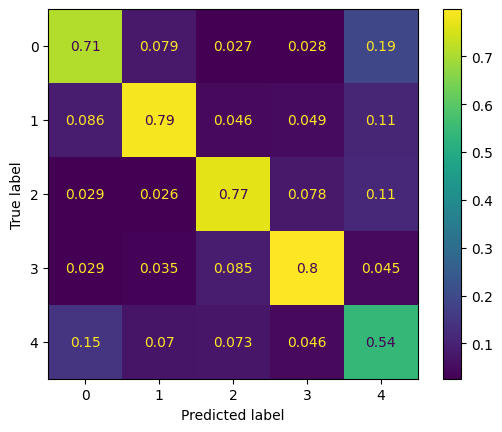

In [26]:
disp = ConfusionMatrixDisplay(result, display_labels=[0,1,2,3,4])
disp.plot()
plt.show()

In [17]:
ES = True
LR = False
IMAGE_SIZE = 255
BATCH_SIZE = 196
for i in range(0, 1):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(dataset_path, 2)
    (m, df_hist) = run_experiment_lr("use_pre_trained_model_convnext_tiny_equal", i, use_pre_trained_model_convnext_tiny_equal, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.


NameError: name 'use_pre_trained_model_convnext_tiny_equal' is not defined

In [32]:
ES = True
LR = False
IMAGE_SIZE = 160
BATCH_SIZE = 196
for i in range(0, 1):
    ds_train, ds_valid = get_equal_split_aug_dataset_raw(dataset_path, 1)
    (m, df_hist) = run_experiment_lr("use_pre_trained_model_convnext_tiny_equal_inctop", i, use_pre_trained_model_convnext_tiny_equal_inctop, ds_train, ds_valid)
    df_results = add_results(df_results, df_hist)
    
df_results.to_csv(WORKING_DATA / "results.csv")

Found 5435 files belonging to 5 classes.
Using 4077 files for training.
Using 1358 files for validation.
Using EarlyStopping
Epoch 1/50


ValueError: in user code:

    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py", line 1150, in train_step
        y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/conda/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_6' (type Sequential).
    
    Input 0 of layer "convnext_tiny" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 160, 160, 3)
    
    Call arguments received by layer 'sequential_6' (type Sequential):
      • inputs=tf.Tensor(shape=(None, 160, 160, 3), dtype=float32)
      • training=True
      • mask=None


In [15]:
df_results = pd.read_csv(WORKING_DATA / "results.csv")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

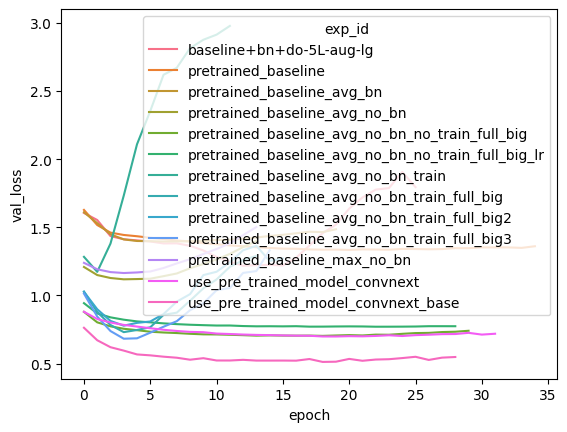

In [31]:
plot_experiments_comp(df_results,["use_pre_trained_model_convnext_base", "use_pre_trained_model_convnext", "pretrained_baseline_avg_no_bn_train_full_big3", "pretrained_baseline_avg_no_bn_train_full_big2", "pretrained_baseline_avg_no_bn_no_train_full_big_lr", "pretrained_baseline_avg_no_bn_no_train_full_big", "pretrained_baseline_avg_no_bn_train_full_big", "pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "baseline+bn+do-5L-aug-lg"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

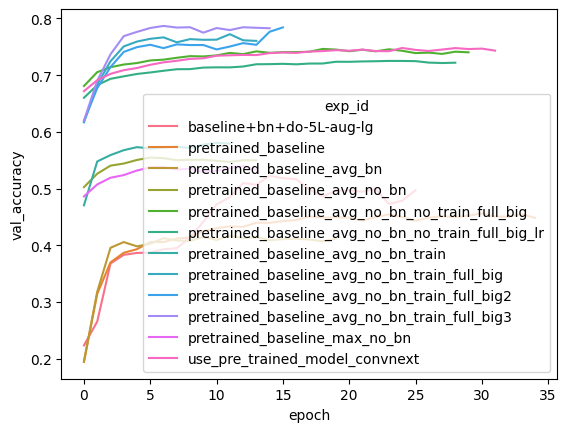

In [14]:
plot_experiments_comp(df_results,["use_pre_trained_model_convnext", "pretrained_baseline_avg_no_bn_train_full_big3", "pretrained_baseline_avg_no_bn_train_full_big2", "pretrained_baseline_avg_no_bn_no_train_full_big_lr", "pretrained_baseline_avg_no_bn_no_train_full_big", "pretrained_baseline_avg_no_bn_train_full_big", "pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "baseline+bn+do-5L-aug-lg"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

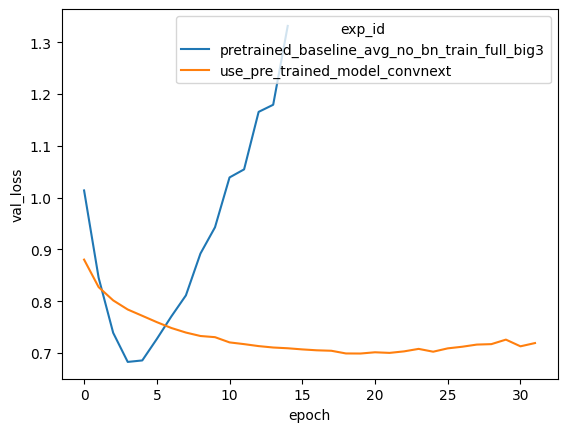

In [27]:
plot_experiments_comp(df_results,["use_pre_trained_model_convnext", "use_pre_trained_model_convnext", "pretrained_baseline_avg_no_bn_train_full_big3"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

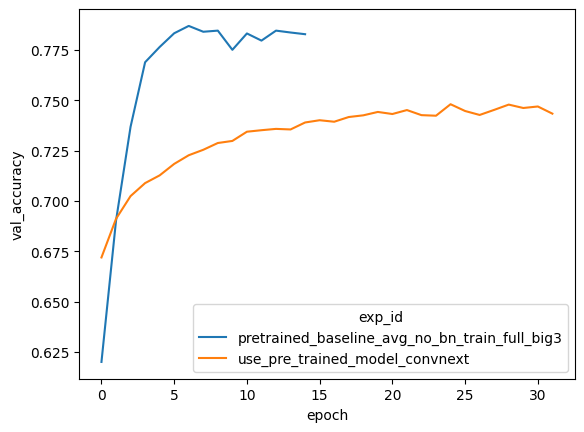

In [28]:
plot_experiments_comp(df_results,["use_pre_trained_model_convnext", "use_pre_trained_model_convnext", "pretrained_baseline_avg_no_bn_train_full_big3"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

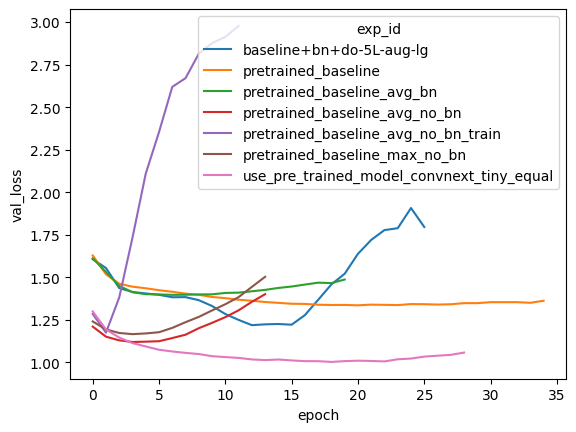

In [20]:
plot_experiments_comp(df_results,["use_pre_trained_model_convnext_tiny_equal", "pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "baseline+bn+do-5L-aug-lg"], "val_loss")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

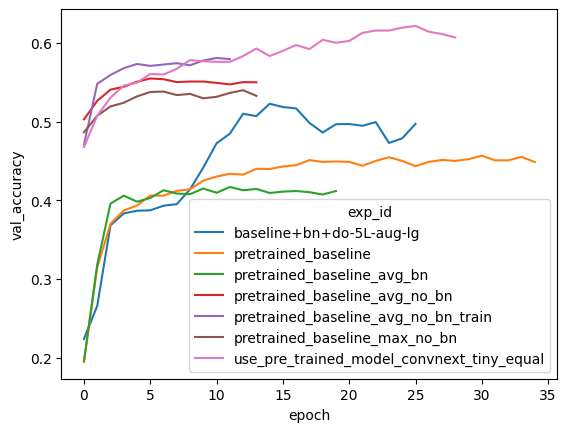

In [21]:
plot_experiments_comp(df_results,["use_pre_trained_model_convnext_tiny_equal", "pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "baseline+bn+do-5L-aug-lg"], "val_accuracy")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to 

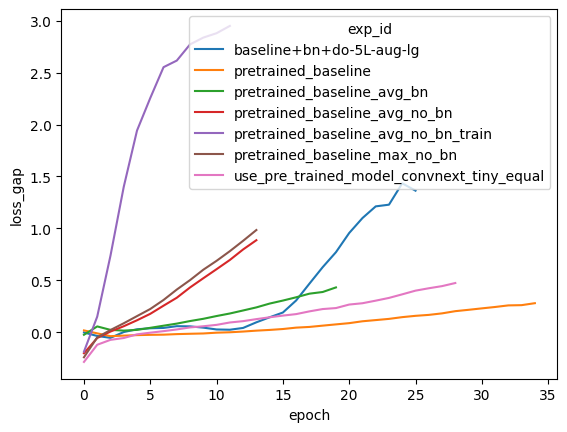

In [22]:
plot_experiments_comp(df_results,["use_pre_trained_model_convnext_tiny_equal", "pretrained_baseline_avg_no_bn_train", "pretrained_baseline_max_no_bn", "pretrained_baseline_avg_no_bn", "pretrained_baseline_avg_bn", "pretrained_baseline", "baseline+bn+do-5L-aug-lg"], "loss_gap")

In [33]:
df_results.to_csv(WORKING_DATA / "results.csv")

In [21]:
df_results[df_results.exp_id=="pretrained_baseline_avg_no_bn_train_full_big"]

Empty DataFrame
Columns: [Unnamed: 0.4, Unnamed: 0.3, Unnamed: 0.2, Unnamed: 0.1, Unnamed: 0, index, loss, accuracy, val_loss, val_accuracy, exp_id, sub_exp_id, epoch, lr]
Index: []

Useful links found so far:
    
https://keras.io/api/data_loading/image/

https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory

https://keras.io/api/applications/vgg/

https://keras.io/api/applications/mobilenet/#mobilenetv2-function

https://keras.io/api/models/model_training_apis/

https://stackoverflow.com/questions/66715975/class-weights-in-cnn

https://www.kaggle.com/code/ryanholbrook/overfitting-and-underfitting